In [1]:
!pip install -r requirements.txt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import torch
import torchaudio
import torchaudio.transforms as T

import librosa

from pyannote.audio import Pipeline
from pyannote.core import Annotation, Segment
from pyannote.audio.pipelines.utils.hook import ProgressHook
from pyannote.metrics.diarization import DiarizationErrorRate


In [3]:
audio_file = "./input/Mode_élection_des_conseils_municipaux_Lyon_Marseille_complet.wav"

In [4]:
if torch.cuda.is_available():
    gpu_number = 2

    # Check if the specified GPU number is valid
    if gpu_number < torch.cuda.device_count():
        torch.cuda.set_device(gpu_number)
        device = torch.device(f'cuda:{gpu_number}')
        print(f"CUDA is available. Using GPU: {gpu_number} ({torch.cuda.get_device_name(gpu_number)})")
    else:
        print(f"Warning: GPU {gpu_number} is not available. Using default GPU (0) or CPU if none.")
        device = torch.device("cuda")
        if torch.cuda.device_count() > 0:
            print(f"Falling back to GPU 0: {torch.cuda.get_device_name(0)}")
        else:
            device = torch.device("cpu")
            print("No GPUs available, falling back to CPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Processing will happen on the CPU.")

CUDA is available. Using GPU: 2 (Tesla V100-PCIE-16GB)


## Diarization

In [5]:
pipeline = Pipeline.from_pretrained(
  "pyannote/speaker-diarization-3.1",
  use_auth_token="os.getenv")
pipeline.to(device)

### Générate rttm from transcription


##### Qu'est-ce qu'un fichier RTTM ?

Un **fichier RTTM** (Rich Transcription Time Marked) est un format textuel standardisé utilisé pour décrire des **segments audio avec des informations temporelles et attributives**. Il est essentiel dans les domaines de la reconnaissance vocale et de la diarisation de locuteurs.

---
##### Structure d'un fichier RTTM

Chaque ligne d'un fichier RTTM représente un segment de parole et est composée de 11 champs, séparés par des espaces :

Voici les champs clés :

* **`TYPE`** : Toujours `SPEAKER`.
* **`ID_FICHIER`** : L'identifiant unique du fichier audio.
* **`CANAL_LOCUTEUR`** : Généralement `1` pour le canal principal.
* **`DEBUT`** : Le temps de début du segment en secondes.
* **`DURÉE`** : La durée du segment en secondes.
* **`<NA>`** : Ces champs sont des marqueurs "non applicable" et sont toujours `<NA>`.
* **`NOM_LOCUTEUR`** : L'identifiant unique du locuteur (ex: `locuteurA`, `SPK001`).

##### Objectif d'un fichier RTTM

L'objectif principal d'un fichier RTTM est de fournir une **transcription temporelle détaillée** du contenu audio. Il est crucial pour :

* La **diarisation de locuteurs** : identifier qui parle et quand.
* L'**évaluation de systèmes** : comparer les performances de la reconnaissance vocale ou de la diarisation.
* L'**annotation de données** : créer des ensembles de données étiquetés pour l'apprentissage automatique.

En bref, le RTTM sert de **feuille de route** précise du dialogue dans un fichier audio.

In [6]:
def generate_rttm_from_xml(xml_file_path, output_dir="./output", file_id=None, default_duration=5.0):
    """
    Génère un fichier RTTM à partir d'un fichier XML de retranscription parlementaire.

    Args:
        xml_file_path (str): Le chemin vers le fichier XML d'entrée.
        output_dir (str, optional): Le répertoire où le fichier RTTM sera sauvegardé.
                                    Par défaut, "./output".
        file_id (str, optional): L'identifiant unique à utiliser dans le fichier RTTM
                                 (souvent le nom du fichier audio associé).
                                 Par défaut, le nom du fichier XML sans extension.
        default_duration (float, optional): La durée par défaut à utiliser pour chaque segment
                                            si la durée réelle ne peut pas être déterminée
                                            à partir du XML. Par défaut, 5.0 secondes.

    Returns:
        str: Le chemin complet du fichier RTTM généré, ou None en cas d'erreur.
    """
    if not os.path.exists(xml_file_path):
        print(f"Erreur : Le fichier XML spécifié n'existe pas : {xml_file_path}")
        return None

    # Définir l'identifiant du fichier si non fourni
    if file_id is None:
        file_id = os.path.splitext(os.path.basename(xml_file_path))[0]

    try:
        # Charger et parser le fichier XML
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
    except ET.ParseError as e:
        print(f"Erreur lors du parsing du fichier XML {xml_file_path} : {e}")
        return None

    # Gérer les namespaces
    ns = {'ns': 'http://schemas.assemblee-nationale.fr/referentiel'}

    # Préparer la sortie RTTM
    rttm_lines = []

    # Pour garder une trace des orateurs (non directement utilisé pour RTTM, mais utile)
    orateur_id_map = {}

    # Trouver tous les blocs <paragraphe> avec un attribut "stime" dans le <texte>
    for paragraphe in root.findall(".//ns:paragraphe", ns):
        texte_elem = paragraphe.find("ns:texte", ns)
        if texte_elem is not None and "stime" in texte_elem.attrib:
            try:
                stime = float(texte_elem.attrib["stime"])
            except ValueError:
                print(f"Avertissement: stime invalide trouvé '{texte_elem.attrib['stime']}'. Passage du segment.")
                continue

            # La durée réelle n'est pas directement dans l'XML fourni,
            # on utilise la durée par défaut.
            # Si vous avez une balise 'etime' ou 'duration' dans votre XML,
            # c'est ici que vous l'extrairiez.
            duration = default_duration

            # Extraire l'orateur
            orateur_elem = paragraphe.find(".//ns:orateur/ns:nom", ns)
            speaker = orateur_elem.text.strip() if orateur_elem is not None else "UNKNOWN"

            # Nettoyer le nom pour créer un speaker_id valide (alphanumérique + underscores)
            speaker_id = re.sub(r"[^\w]", "_", speaker)

            # Ajouter au mapping
            if speaker_id not in orateur_id_map:
                orateur_id_map[speaker_id] = speaker

            # Écrire la ligne RTTM
            # Format RTTM: Type file_id channel_id start_time duration <NA> <NA> speaker_id <NA> <NA>
            rttm_line = f"SPEAKER {file_id} 1 {stime:.2f} {duration:.2f} <NA> <NA> {speaker_id} <NA> <NA>"
            rttm_lines.append(rttm_line)

    # Assurez-vous que le répertoire de sortie existe
    os.makedirs(output_dir, exist_ok=True)
    
    # Chemin complet du fichier RTTM de sortie
    output_rttm_path = os.path.join(output_dir, f"reference_from_xml.rttm")

    # Sauvegarder le fichier RTTM
    with open(output_rttm_path, "w", encoding="utf-8") as f:
        for line in rttm_lines:
            f.write(line + "\n")

    print(f"Fichier RTTM généré : {output_rttm_path} avec {len(rttm_lines)} interventions.")
    return output_rttm_path

In [7]:
rttm_file = generate_rttm_from_xml(
        xml_file_path="./input/retranscription1.xml",
        output_dir="./output",
        file_id="my_parliament_audio", # Nom que vous donneriez à votre fichier audio
        default_duration=5.0
    )

Fichier RTTM généré : ./output/reference_from_xml.rttm avec 500 interventions.


In [8]:
def load_rttm(rttm_path):
    """Charge un fichier RTTM"""
    annotation = Annotation()
    with open(rttm_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            start = float(parts[3])
            duration = float(parts[4])
            speaker = parts[7]
            segment = Segment(start, start + duration)
            annotation[segment] = speaker
    return annotation

def count_speakers(annotation):
    """Compte le nombre unique de speakers"""
    return len(set(annotation.labels()))


Nombre de speakers

In [9]:
num_speakers =count_speakers(load_rttm("./output/reference_from_xml.rttm"))
num_speakers = max(num_speakers, 1)  # Assurer au moins un speaker
num_speakers

54

In [12]:
with ProgressHook() as hook:
    diarization = pipeline(audio_file, num_speakers=num_speakers,hook=hook)
    speakers = []

for segment, track, label in diarization.itertracks(yield_label=True):
    speakers.append(label)

speaker_counts = Counter(speakers)
num_speakers = len(speaker_counts)

print(f"\nNumber of distinct speakers detected: {num_speakers}")

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


Number of distinct speakers detected: 54


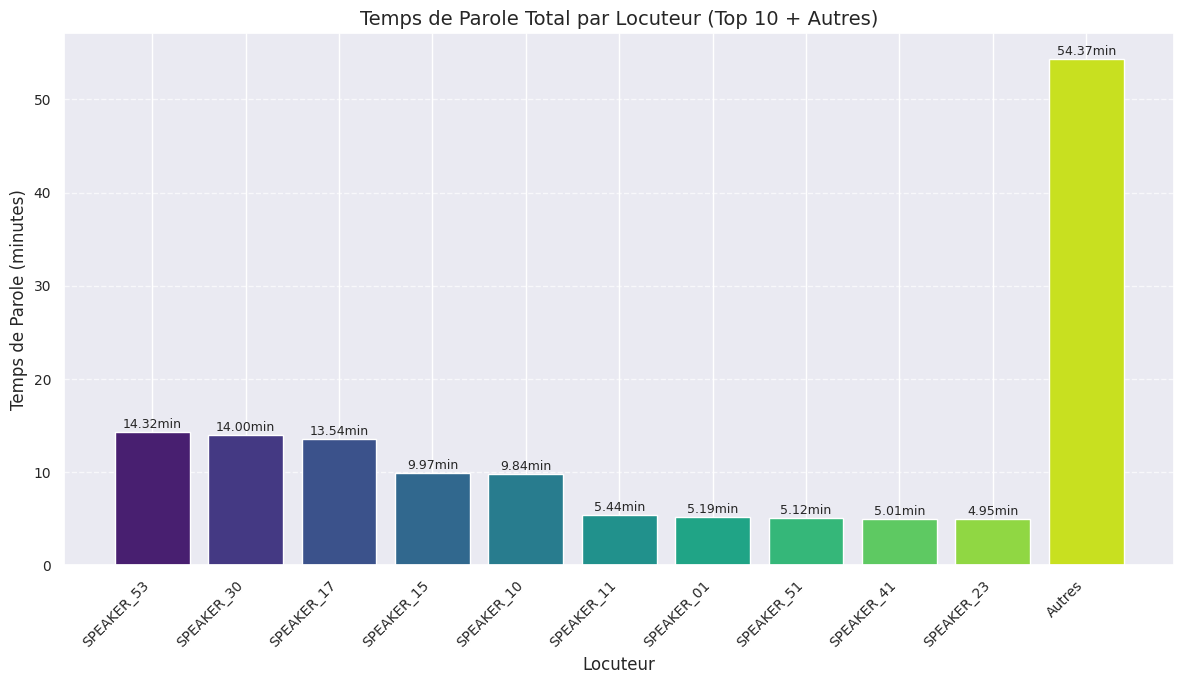


--- Speaking Times ---
SPEAKER_53: 859.34 seconds (14.32 minutes)
SPEAKER_30: 840.12 seconds (14.00 minutes)
SPEAKER_17: 812.53 seconds (13.54 minutes)
SPEAKER_15: 598.37 seconds (9.97 minutes)
SPEAKER_10: 590.12 seconds (9.84 minutes)
SPEAKER_11: 326.35 seconds (5.44 minutes)
SPEAKER_01: 311.63 seconds (5.19 minutes)
SPEAKER_51: 307.21 seconds (5.12 minutes)
SPEAKER_41: 300.73 seconds (5.01 minutes)
SPEAKER_23: 297.24 seconds (4.95 minutes)
SPEAKER_45: 293.08 seconds (4.88 minutes)
SPEAKER_22: 270.30 seconds (4.51 minutes)
SPEAKER_26: 216.27 seconds (3.60 minutes)
SPEAKER_03: 185.05 seconds (3.08 minutes)
SPEAKER_24: 177.93 seconds (2.97 minutes)
SPEAKER_20: 157.48 seconds (2.62 minutes)
SPEAKER_07: 116.99 seconds (1.95 minutes)
SPEAKER_00: 111.49 seconds (1.86 minutes)
SPEAKER_42: 109.75 seconds (1.83 minutes)
SPEAKER_32: 103.71 seconds (1.73 minutes)
SPEAKER_12: 102.52 seconds (1.71 minutes)
SPEAKER_49: 99.11 seconds (1.65 minutes)
SPEAKER_04: 95.34 seconds (1.59 minutes)
SPEAKER_0

In [88]:
speaker_durations = defaultdict(float)
for segment, _, label in diarization.itertracks(yield_label=True):
    duration = segment.duration
    speaker_durations[label] += duration

# Trier les locuteurs par durée de parole décroissante
sorted_speakers_by_duration = sorted(speaker_durations.items(), key=lambda item: item[1], reverse=True)

# --- Amélioration du Graphique à Barres : Top N Locuteurs + Autres ---
N_TOP_SPEAKERS = 10 # Nombre de locuteurs à afficher individuellement

if not speaker_durations:
    print("Aucun locuteur détecté pour le tracé.")
else:
    # Extraire les N premiers locuteurs
    top_n_speakers_data = sorted_speakers_by_duration[:N_TOP_SPEAKERS]

    # Calculer la durée pour la catégorie "Autres"
    other_duration = sum(item[1] for item in sorted_speakers_by_duration[N_TOP_SPEAKERS:])

    # Préparer les données pour le tracé
    speakers_to_plot = [item[0] for item in top_n_speakers_data]
    durations_to_plot = [item[1] for item in top_n_speakers_data]

    if other_duration > 0:
        speakers_to_plot.append("Autres")
        durations_to_plot.append(other_duration)

    # Convertir les durées en minutes pour le tracé
    durations_minutes_to_plot = [d / 60 for d in durations_to_plot]

    # Créer le graphique à barres amélioré
    plt.figure(figsize=(12, 7)) # Taille de figure augmentée pour 10+1 barres
    bars = plt.bar(speakers_to_plot, durations_minutes_to_plot, color=sns.color_palette("viridis", len(speakers_to_plot)))

    # Ajouter la durée en minutes au-dessus de chaque barre
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f"{yval:.2f}min", ha='center', va='bottom', fontsize=9)

    plt.xlabel("Locuteur", fontsize=12)
    plt.ylabel("Temps de Parole (minutes)", fontsize=12)
    plt.title(f"Temps de Parole Total par Locuteur (Top {N_TOP_SPEAKERS} + Autres)", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10) # Rotation et taille de police pour la lisibilité
    plt.yticks(fontsize=10)
    plt.tight_layout() # Ajuster la mise en page pour éviter le chevauchement des étiquettes
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Also print the numerical results
print("\n--- Speaking Times ---")
for speaker, duration in sorted_speakers_by_duration:
    print(f"{speaker}: {duration:.2f} seconds ({duration/60:.2f} minutes)")

2. camemberg

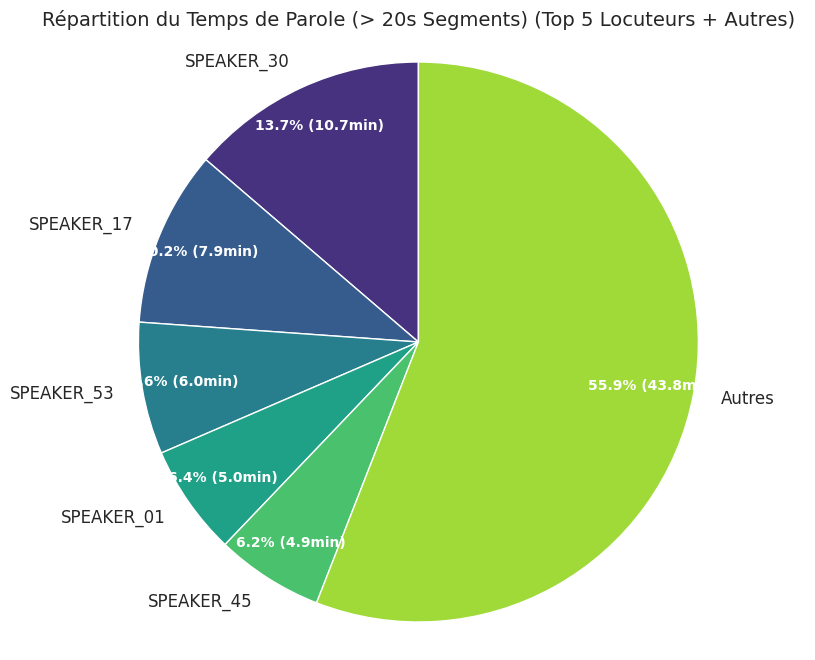


--- Répartition détaillée du temps de parole (Segments > 1 minute) ---
SPEAKER_30: 643.87 secondes (10.73 minutes)
SPEAKER_17: 476.67 secondes (7.94 minutes)
SPEAKER_53: 357.73 secondes (5.96 minutes)
SPEAKER_01: 299.62 secondes (4.99 minutes)
SPEAKER_45: 291.36 secondes (4.86 minutes)
Autres: 2625.50 secondes (43.76 minutes)
Temps total de parole affiché (Segments > 1 min): 4694.74 secondes (78.25 minutes)


In [89]:
speaker_durations_filtered = defaultdict(float)
for segment, _, label in diarization.itertracks(yield_label=True):
    duration = segment.duration
    if duration >= 20.0: # Condition: segment doit durer au moins 20 secondes
        speaker_durations_filtered[label] += duration

if not speaker_durations_filtered:
    print("Aucun locuteur n'a de prise de parole de plus de 20 secondes pour créer le camembert.")
else:
    # Trier les locuteurs par durée de parole décroissante (basé sur les segments filtrés)
    sorted_speakers_filtered = sorted(speaker_durations_filtered.items(), key=lambda item: item[1], reverse=True)

    # Prendre les 5 premiers locuteurs filtrés
    top_5_speakers_filtered = sorted_speakers_filtered[:5]

    # Calculer la durée pour la catégorie "Autres" parmi les segments filtrés
    other_duration_filtered = 0
    for i in range(5, len(sorted_speakers_filtered)):
        other_duration_filtered += sorted_speakers_filtered[i][1]

    # Préparer les données pour le camembert
    labels_pie = [speaker for speaker, _ in top_5_speakers_filtered]
    sizes_pie = [duration for _, duration in top_5_speakers_filtered]

    # Ajouter "Autres" si nécessaire
    if other_duration_filtered > 0:
        labels_pie.append("Autres")
        sizes_pie.append(other_duration_filtered)

    # Calculer la durée totale en secondes pour le calcul des minutes dans le camembert
    total_duration_seconds_filtered = sum(sizes_pie)

    # Créer le camembert
    plt.figure(figsize=(10, 8))
    sns.set_palette("viridis")
    # autopct affiche le pourcentage et la durée en minutes pour chaque tranche
    wedges, texts, autotexts = plt.pie(
        sizes_pie,
        labels=labels_pie,
        autopct=lambda p: f'{p:.1f}% ({p/100 * total_duration_seconds_filtered / 60:.1f}min)',
        startangle=90,
        pctdistance=0.85
    )

    # Améliorer la lisibilité du texte de pourcentage
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_weight('bold')
        # Ajuster la taille de la police pour les pourcentages (optionnel)
        autotext.set_fontsize(10)

    # Améliorer la lisibilité du texte des labels
    for text in texts:
        text.set_fontsize(12) # Ajuster la taille de la police pour les labels

    plt.title("Répartition du Temps de Parole (> 20s Segments) (Top 5 Locuteurs + Autres)", fontsize=14)
    plt.axis('equal') # Assure que le camembert est un cercle parfait
    plt.show()

    # Afficher les détails en console pour une référence rapide
    print("\n--- Répartition détaillée du temps de parole (Segments > 1 minute) ---")
    for speaker, duration in top_5_speakers_filtered:
        print(f"{speaker}: {duration:.2f} secondes ({duration/60:.2f} minutes)")
    if other_duration_filtered > 0:
        print(f"Autres: {other_duration_filtered:.2f} secondes ({other_duration_filtered/60:.2f} minutes)")
    print(f"Temps total de parole affiché (Segments > 1 min): {total_duration_seconds_filtered:.2f} secondes ({total_duration_seconds_filtered/60:.2f} minutes)")


In [90]:
long_speech_segments_by_speaker = defaultdict(list)
for segment, _, label in diarization.itertracks(yield_label=True):
    if segment.duration >= 20.0: # 20.0 secondes = 20 secondes
        long_speech_segments_by_speaker[label].append(segment)

if not long_speech_segments_by_speaker:
    print("Aucun locuteur n'a de segments de parole de plus de 20 secondes dans l'ensemble de l'audio.")
else:
    # Trier les locuteurs par leur durée totale de segments longs, pour un affichage cohérent
    # Nous utilisons ici les clés du dictionnaire pour s'assurer que nous n'affichons que les locuteurs qui ont des segments longs
    sorted_speakers_for_display = sorted(long_speech_segments_by_speaker.keys(),
                                         key=lambda speaker: sum(s.duration for s in long_speech_segments_by_speaker[speaker]),
                                         reverse=True)

    for speaker_label in sorted_speakers_for_display:
        segments_for_this_speaker = sorted(long_speech_segments_by_speaker[speaker_label], key=lambda s: s.start)
        
        # Calculer la durée totale des segments longs pour ce locuteur (pour l'affichage)
        total_long_duration_speaker = sum(s.duration for s in segments_for_this_speaker)

        print(f"\nLocuteur: {speaker_label} (Durée totale des segments > 1min: {total_long_duration_speaker/60:.2f} minutes)")
        
        for i, segment in enumerate(segments_for_this_speaker):
            start_min = int(segment.start // 60)
            start_sec = int(segment.start % 60)
            end_min = int(segment.end // 60)
            end_sec = int(segment.end % 60)
            
            # Formater les secondes avec deux chiffres (ex: 05 au lieu de 5)
            segment_duration_min = int(segment.duration // 60)
            segment_duration_sec = int(segment.duration % 60)

            print(f"  - Segment {i+1}: [{start_min:02d}:{start_sec:02d} - {end_min:02d}:{end_sec:02d}] "
                  f"(Durée: {segment_duration_min}m {segment_duration_sec:02d}s)")



Locuteur: SPEAKER_30 (Durée totale des segments > 1min: 10.73 minutes)
  - Segment 1: [25:19 - 25:40] (Durée: 0m 21s)
  - Segment 2: [26:02 - 26:25] (Durée: 0m 23s)
  - Segment 3: [26:26 - 26:55] (Durée: 0m 29s)
  - Segment 4: [48:30 - 50:17] (Durée: 1m 46s)
  - Segment 5: [50:17 - 50:42] (Durée: 0m 25s)
  - Segment 6: [64:32 - 65:06] (Durée: 0m 34s)
  - Segment 7: [72:55 - 73:24] (Durée: 0m 29s)
  - Segment 8: [74:00 - 74:50] (Durée: 0m 50s)
  - Segment 9: [87:55 - 89:21] (Durée: 1m 26s)
  - Segment 10: [106:14 - 107:07] (Durée: 0m 53s)
  - Segment 11: [127:56 - 128:50] (Durée: 0m 53s)
  - Segment 12: [156:00 - 156:20] (Durée: 0m 20s)
  - Segment 13: [156:33 - 157:29] (Durée: 0m 56s)
  - Segment 14: [157:30 - 157:54] (Durée: 0m 24s)
  - Segment 15: [169:02 - 169:32] (Durée: 0m 30s)

Locuteur: SPEAKER_17 (Durée totale des segments > 1min: 7.94 minutes)
  - Segment 1: [32:52 - 33:13] (Durée: 0m 20s)
  - Segment 2: [33:18 - 33:44] (Durée: 0m 26s)
  - Segment 3: [51:29 - 52:10] (Durée: 0

In [91]:
waveform_torch, sample_rate = torchaudio.load(audio_file)
if waveform_torch.ndim > 1 and waveform_torch.shape[0] > 1:
    waveform_np = waveform_torch[0, :].cpu().numpy() # Prendre le premier canal si stéréo
else:
    waveform_np = waveform_torch.squeeze().cpu().numpy()

In [92]:
speakers = []
raw_speaker_segments = defaultdict(list) # Pour stocker les segments bruts initialement
speaker_durations = defaultdict(float)

FUSION_GAP_THRESHOLD = 10

for segment, track, label in diarization.itertracks(yield_label=True):
    speakers.append(label)
    raw_speaker_segments[label].append(segment)

In [93]:
speaker_segments = defaultdict(list) # Ce dictionnaire contiendra les segments fusionnés

for label, segments_list in raw_speaker_segments.items():
    if not segments_list:
        continue

    # Trier les segments par heure de début pour s'assurer qu'ils sont dans le bon ordre
    segments_list.sort(key=lambda s: s.start)

    merged_segments = []
    current_segment = segments_list[0]

    for i in range(1, len(segments_list)):
        next_segment = segments_list[i]

        # Calculer l'intervalle entre la fin du segment actuel et le début du suivant
        gap = next_segment.start - current_segment.end

        if gap <= FUSION_GAP_THRESHOLD:
            # Les segments sont suffisamment proches, fusionner en un seul
            # Le nouveau segment commence au début du current_segment et finit à la fin du next_segment
            current_segment = Segment(current_segment.start, next_segment.end)
        else:
            # La pause est trop longue, le segment actuel est terminé
            merged_segments.append(current_segment)
            # Démarrer un nouveau segment avec le next_segment
            current_segment = next_segment
    
    # Ajouter le dernier segment (fusionné ou non)
    merged_segments.append(current_segment)
    
    speaker_segments[label] = merged_segments
    
    # Recalculer la durée totale après la fusion
    for seg in merged_segments:
        speaker_durations[label] += seg.duration

In [94]:
speaker_counts = Counter(speakers) # Note: speaker_counts reste basé sur les segments initiaux, ce qui est OK
num_speakers = len(speaker_counts) # Reste le même nombre de locuteurs uniques

print(f"\nNumber of distinct speakers detected (based on raw diarization): {num_speakers}")

print("\nDetailed speaker breakdown (by number of initial segments):")
for speaker_label, count in speaker_counts.items():
    print(f"- {speaker_label}: {count} raw segments")


Number of distinct speakers detected (based on raw diarization): 54

Detailed speaker breakdown (by number of initial segments):
- SPEAKER_10: 124 raw segments
- SPEAKER_09: 38 raw segments
- SPEAKER_32: 22 raw segments
- SPEAKER_20: 12 raw segments
- SPEAKER_11: 45 raw segments
- SPEAKER_08: 54 raw segments
- SPEAKER_41: 52 raw segments
- SPEAKER_03: 24 raw segments
- SPEAKER_06: 35 raw segments
- SPEAKER_33: 1 raw segments
- SPEAKER_30: 62 raw segments
- SPEAKER_31: 17 raw segments
- SPEAKER_28: 5 raw segments
- SPEAKER_45: 7 raw segments
- SPEAKER_50: 10 raw segments
- SPEAKER_00: 15 raw segments
- SPEAKER_01: 8 raw segments
- SPEAKER_07: 57 raw segments
- SPEAKER_35: 4 raw segments
- SPEAKER_17: 90 raw segments
- SPEAKER_19: 11 raw segments
- SPEAKER_53: 108 raw segments
- SPEAKER_16: 17 raw segments
- SPEAKER_15: 76 raw segments
- SPEAKER_25: 3 raw segments
- SPEAKER_26: 14 raw segments
- SPEAKER_22: 9 raw segments
- SPEAKER_34: 2 raw segments
- SPEAKER_51: 21 raw segments
- SPEA

In [95]:
print("\nDiarization timeline (merged segments):")
# Afficher la timeline des segments fusionnés pour vérifier
for label, segments in speaker_segments.items():
    # Convertir la durée totale du locuteur en minutes pour l'affichage du titre
    total_merged_duration_minutes = speaker_durations[label] / 60
    print(f"\nSpeaker: {label} (Total merged duration: {total_merged_duration_minutes:.2f} minutes)")
    
    for seg in segments:
        # Calculer et formater le temps de début du segment en MM:SS
        start_min = int(seg.start // 60)
        start_sec = int(seg.start % 60)
        
        # Calculer et formater le temps de fin du segment en MM:SS
        end_min = int(seg.end // 60)
        end_sec = int(seg.end % 60)
        
        # Calculer et formater la durée du segment en Mm Ss
        segment_duration_min = int(seg.duration // 60)
        segment_duration_sec = int(seg.duration % 60)

        print(f"  [{start_min:02d}:{start_sec:02d} - {end_min:02d}:{end_sec:02d}] "
              f"(Duration: {segment_duration_min}m {segment_duration_sec:02d}s)")


Diarization timeline (merged segments):

Speaker: SPEAKER_10 (Total merged duration: 12.08 minutes)
  [14:34 - 15:02] (Duration: 0m 28s)
  [16:50 - 16:57] (Duration: 0m 06s)
  [19:08 - 19:13] (Duration: 0m 04s)
  [22:59 - 23:02] (Duration: 0m 03s)
  [24:24 - 24:49] (Duration: 0m 24s)
  [28:42 - 28:45] (Duration: 0m 03s)
  [34:18 - 34:33] (Duration: 0m 14s)
  [39:14 - 39:32] (Duration: 0m 17s)
  [50:46 - 50:51] (Duration: 0m 05s)
  [53:10 - 53:21] (Duration: 0m 11s)
  [53:32 - 53:53] (Duration: 0m 21s)
  [54:52 - 54:56] (Duration: 0m 03s)
  [55:51 - 55:56] (Duration: 0m 05s)
  [58:48 - 58:51] (Duration: 0m 03s)
  [63:37 - 64:01] (Duration: 0m 23s)
  [66:00 - 66:10] (Duration: 0m 09s)
  [68:17 - 68:24] (Duration: 0m 07s)
  [74:50 - 75:04] (Duration: 0m 13s)
  [76:02 - 76:02] (Duration: 0m 00s)
  [80:07 - 80:12] (Duration: 0m 04s)
  [81:28 - 81:29] (Duration: 0m 01s)
  [85:46 - 85:53] (Duration: 0m 06s)
  [86:52 - 87:02] (Duration: 0m 10s)
  [89:27 - 89:31] (Duration: 0m 04s)
  [90:52 - 

In [96]:
print("\n--- Speaker Activity Summary (by total duration) ---")
sorted_speakers_by_duration = sorted(speaker_durations.items(), key=lambda item: item[1], reverse=True)

for speaker, duration in sorted_speakers_by_duration:
    # Convert duration from seconds to hh:mm:ss format
    hours = int(duration // 3600)
    minutes = int((duration % 3600) // 60)
    seconds = int(duration % 60)
    
    formatted_duration = f"{hours:02}:{minutes:02}:{seconds:02}"
    
    print(f"- {speaker}: {formatted_duration}")

N_MOST_ACTIVE_SPEAKERS = 5
top_active_speakers = [speaker for speaker, _ in sorted_speakers_by_duration[:N_MOST_ACTIVE_SPEAKERS]]

print(f"\n--- Top {len(top_active_speakers)} Most Active Speakers for Prosodic Analysis ---")
for speaker in top_active_speakers:
    print(f"- {speaker}")


--- Speaker Activity Summary (by total duration) ---
- SPEAKER_53: 00:15:24
- SPEAKER_30: 00:14:37
- SPEAKER_17: 00:14:23
- SPEAKER_10: 00:12:04
- SPEAKER_15: 00:10:42
- SPEAKER_11: 00:05:57
- SPEAKER_41: 00:05:45
- SPEAKER_51: 00:05:22
- SPEAKER_01: 00:05:13
- SPEAKER_23: 00:05:04
- SPEAKER_45: 00:04:54
- SPEAKER_22: 00:04:33
- SPEAKER_26: 00:03:45
- SPEAKER_03: 00:03:22
- SPEAKER_24: 00:03:01
- SPEAKER_20: 00:02:40
- SPEAKER_07: 00:02:36
- SPEAKER_00: 00:02:06
- SPEAKER_08: 00:02:01
- SPEAKER_32: 00:01:52
- SPEAKER_42: 00:01:49
- SPEAKER_12: 00:01:42
- SPEAKER_49: 00:01:40
- SPEAKER_04: 00:01:38
- SPEAKER_36: 00:01:36
- SPEAKER_05: 00:01:34
- SPEAKER_31: 00:01:27
- SPEAKER_35: 00:01:14
- SPEAKER_09: 00:01:13
- SPEAKER_47: 00:01:03
- SPEAKER_50: 00:01:01
- SPEAKER_06: 00:01:01
- SPEAKER_16: 00:01:01
- SPEAKER_21: 00:00:50
- SPEAKER_34: 00:00:50
- SPEAKER_02: 00:00:47
- SPEAKER_19: 00:00:43
- SPEAKER_40: 00:00:43
- SPEAKER_46: 00:00:39
- SPEAKER_27: 00:00:38
- SPEAKER_44: 00:00:36
- S

- `N_FFT` (int): Représente le nombre de points pour la **Transformée de Fourier Rapide (FFT)**.
    Cette valeur détermine la résolution en fréquence de l'analyse. Elle est généralement
    une puissance de 2 pour des raisons d'efficacité de calcul (ex: 1024, 2048).
    Une valeur plus élevée offre une meilleure résolution en fréquence mais une moins bonne
    résolution temporelle.

- `HOP_LENGTH` (int): Indique le nombre d'échantillons qui séparent le début de deux
    trames successives lors de l'analyse spectrale.
    Un `HOP_LENGTH` plus petit entraîne un chevauchement plus important entre les trames,
    améliorant la résolution temporelle et la fluidité de l'analyse, mais augmentant
    le coût computationnel.

- `MIN_SEGMENT_SAMPLES` (int): Définit la taille minimale en échantillons qu'un segment
    audio doit avoir pour être considéré comme valide ou pertinent pour l'analyse.
    Ici, sa valeur est fixée à `N_FFT`, ce qui signifie qu'un segment doit contenir
    au moins une trame FFT complète.

- `VOICING_THRESHOLD` (float): Un seuil de confiance utilisé dans les algorithmes de
    détection de la voix (voisement). Les probabilités de voisement (généralement entre 0 et 1)
    qui sont supérieures à ce seuil sont interprétées comme indiquant la présence de voix.
    Par exemple, si le seuil est de 0.7, une probabilité de voisement de 0.8 sera
    considérée comme une détection de voix.

In [97]:
N_FFT = 1024 
HOP_LENGTH = 512
MIN_SEGMENT_SAMPLES = N_FFT
VOICING_THRESHOLD = 0.7
PITCH_MAGNITUDE_THRESHOLD = 0.01

Cette section du code traite les données audio pour chaque locuteur identifié, en extrayant des caractéristiques prosodiques et acoustiques.

Pour chaque locuteur principal (`top_active_speakers`) et chacun de ses segments de parole :

- **Filtrage des segments courts**: Les segments dont la durée est inférieure à `MIN_SEGMENT_SAMPLES` (égal à `N_FFT`) sont ignorés pour assurer une analyse FFT valide.

- **Extraction du Pitch (F0)**: Utilise `librosa.core.piptrack` pour estimer la fréquence fondamentale (F0) de la voix. Les valeurs de pitch non nulles sont collectées avec leurs horodatages correspondants.

- **Extraction de l'Intensité (RMS)**: Calcule l'énergie RMS (Root Mean Square) des segments via `librosa.feature.rms`, puis la convertit en décibels pour représenter l'intensité sonore. Les données d'intensité valides et leurs horodatages sont stockés.

- **Extraction des MFCC (Coefficients Mel-Fréquence Cepstraux)**: Pour un exemple de segment par locuteur (le premier segment d'au moins 2 secondes), les MFCC sont calculés avec `librosa.feature.mfcc`. Ces coefficients sont normalisés (centrés par rapport à leur moyenne) et représentent la texture spectrale du son.


In [98]:
all_speaker_prosody_data = {}

for speaker_label in top_active_speakers:
    speaker_pitches_raw = []
    speaker_intensities_raw = []

    speaker_pitches_contour = []
    speaker_pitches_times = []
    speaker_intensities_contour = []
    speaker_intensities_times = []

    mfcc_example_segment_info = None
    mfcc_example_data = None

    for segment_idx, segment in enumerate(speaker_segments[speaker_label]):
        start_sample = int(segment.start * sample_rate)
        end_sample = int(segment.end * sample_rate)
        segment_audio_np = waveform_np[start_sample:end_sample]

        # --- Étape de correction : Filtrer les segments trop courts ---
        # Si le segment est plus court que la taille minimale requise (N_FFT), on le saute
        if segment_audio_np.size < MIN_SEGMENT_SAMPLES:
            # Optionnel : décommenter pour voir quels segments sont ignorés
            print(f"Skipping segment for {speaker_label} from {segment.start:.2f}s to {segment.end:.2f}s "
                  f"(length={segment_audio_np.size} samples) as it's too short for N_FFT={N_FFT}")
            continue

        # --- Pitch (F0) avec librosa ---
        # Spécifiez n_fft et hop_length pour piptrack
        pitches, _ = librosa.core.piptrack(y=segment_audio_np, sr=sample_rate, 
                                           fmin=75, fmax=500, n_fft=N_FFT, hop_length=HOP_LENGTH)
        
        pitch_values_segment = []
        if pitches.shape[1] > 0: # S'assurer qu'il y a des trames de pitch
            for t_frame in range(pitches.shape[1]):
                index = pitches[:, t_frame].argmax()
                pitch_val = pitches[index, t_frame]
                if pitch_val > 0: # Seulement si un pitch est détecté
                    pitch_values_segment.append(pitch_val)
                    time_point = segment.start + librosa.core.frames_to_time(t_frame, sr=sample_rate, hop_length=HOP_LENGTH)
                    speaker_pitches_times.append(time_point)

        if pitch_values_segment:
            speaker_pitches_raw.extend(pitch_values_segment)
            speaker_pitches_contour.extend(pitch_values_segment)

        # --- Intensity (RMS energy) avec librosa ---
        # Spécifiez frame_length et hop_length pour rms
        rms = librosa.feature.rms(y=segment_audio_np, frame_length=N_FFT, hop_length=HOP_LENGTH)[0]
        intensity_db = librosa.amplitude_to_db(rms, ref=np.max)
        
        intensity_times_segment = librosa.core.frames_to_time(np.arange(len(rms)), sr=sample_rate, hop_length=HOP_LENGTH)

        if np.isfinite(intensity_db).any():
            speaker_intensities_raw.extend(intensity_db[np.isfinite(intensity_db)])
            for i_val, val in enumerate(intensity_db):
                 if np.isfinite(val):
                     speaker_intensities_contour.append(val)
                     speaker_intensities_times.append(segment.start + intensity_times_segment[i_val])

        # --- MFCC avec librosa (pour un exemple de segment) ---
        # Spécifiez n_fft et hop_length pour mfcc
        # Conservez la condition de durée minimale pour l'exemple MFCC
        if mfcc_example_data is None and segment.duration >= 2.0:
            # Ajoutez une vérification pour s'assurer que le segment est assez long même pour le MFCC
            if segment_audio_np.size >= N_FFT: # S'assurer qu'il n'est pas trop court même après filtrage initial
                mfcc_example_segment_info = segment
                mfcc_data = librosa.feature.mfcc(y=segment_audio_np, sr=sample_rate, n_mfcc=13, n_fft=N_FFT, hop_length=HOP_LENGTH)
                mfcc_example_data = mfcc_data - np.mean(mfcc_data, axis=1, keepdims=True)
            else:
                # print(f"MFCC example skipped for {speaker_label} due to short segment even with duration >= 2.0s: {segment.duration:.2f}s")
                pass


    all_speaker_prosody_data[speaker_label] = {
        'pitches_raw': np.array(speaker_pitches_raw),
        'intensities_raw': np.array(speaker_intensities_raw),
        'pitches_contour': np.array(speaker_pitches_contour),
        'pitches_times': np.array(speaker_pitches_times),
        'intensities_contour': np.array(speaker_intensities_contour),
        'intensities_times': np.array(speaker_intensities_times),
        'mfcc_example_segment_info': mfcc_example_segment_info,
        'mfcc_example_data': mfcc_example_data,
    }


Skipping segment for SPEAKER_10 from 4562.71s to 4562.73s (length=270 samples) as it's too short for N_FFT=1024
Skipping segment for SPEAKER_10 from 5874.66s to 5874.69s (length=540 samples) as it's too short for N_FFT=1024
Skipping segment for SPEAKER_10 from 7969.62s to 7969.64s (length=270 samples) as it's too short for N_FFT=1024
Skipping segment for SPEAKER_10 from 9782.35s to 9782.37s (length=270 samples) as it's too short for N_FFT=1024


In [99]:
print(f"\nNumber of distinct speakers detected: {num_speakers}")

print("\nDetailed speaker breakdown (by number of segments):")
for speaker_label, count in speaker_counts.items():
    print(f"- {speaker_label}: {count} segments")

print("\nDiarization timeline (all segments):")
for segment, _, speaker in diarization.itertracks(yield_label=True):
    # Convert start time to hh:mm:ss
    start_seconds = int(segment.start)
    start_hours = start_seconds // 3600
    start_minutes = (start_seconds % 3600) // 60
    start_remaining_seconds = start_seconds % 60
    formatted_start = f"{start_hours:02}:{start_minutes:02}:{start_remaining_seconds:02}"

    # Convert end time to hh:mm:ss
    end_seconds = int(segment.end)
    end_hours = end_seconds // 3600
    end_minutes = (end_seconds % 3600) // 60
    end_remaining_seconds = end_seconds % 60
    formatted_end = f"{end_hours:02}:{end_minutes:02}:{end_remaining_seconds:02}"

    print(f"[{formatted_start} - {formatted_end}]: {speaker}")


Number of distinct speakers detected: 54

Detailed speaker breakdown (by number of segments):
- SPEAKER_10: 124 segments
- SPEAKER_09: 38 segments
- SPEAKER_32: 22 segments
- SPEAKER_20: 12 segments
- SPEAKER_11: 45 segments
- SPEAKER_08: 54 segments
- SPEAKER_41: 52 segments
- SPEAKER_03: 24 segments
- SPEAKER_06: 35 segments
- SPEAKER_33: 1 segments
- SPEAKER_30: 62 segments
- SPEAKER_31: 17 segments
- SPEAKER_28: 5 segments
- SPEAKER_45: 7 segments
- SPEAKER_50: 10 segments
- SPEAKER_00: 15 segments
- SPEAKER_01: 8 segments
- SPEAKER_07: 57 segments
- SPEAKER_35: 4 segments
- SPEAKER_17: 90 segments
- SPEAKER_19: 11 segments
- SPEAKER_53: 108 segments
- SPEAKER_16: 17 segments
- SPEAKER_15: 76 segments
- SPEAKER_25: 3 segments
- SPEAKER_26: 14 segments
- SPEAKER_22: 9 segments
- SPEAKER_34: 2 segments
- SPEAKER_51: 21 segments
- SPEAKER_27: 12 segments
- SPEAKER_39: 8 segments
- SPEAKER_29: 2 segments
- SPEAKER_47: 6 segments
- SPEAKER_44: 3 segments
- SPEAKER_43: 4 segments
- SPEA

In [100]:
print("\n--- Detailed Prosodic Analysis with Time Contours and MFCCs ---")

all_speaker_prosody_data = {}

for speaker_label in top_active_speakers:
    speaker_pitches_raw = []
    speaker_intensities_raw = []

    speaker_pitches_contour = []
    speaker_pitches_times = []
    speaker_intensities_contour = []
    speaker_intensities_times = []

    mfcc_example_segment_info = None
    mfcc_example_data = None

    for segment_idx, segment in enumerate(speaker_segments[speaker_label]):
        start_sample = int(segment.start * sample_rate)
        end_sample = int(segment.end * sample_rate)
        segment_audio_np = waveform_np[start_sample:end_sample]

        # --- 1. Filtrer les segments trop courts ---
        if segment_audio_np.size < MIN_SEGMENT_SAMPLES:
            # print(f"Skipping segment for {speaker_label} from {segment.start:.2f}s to {segment.end:.2f}s "
            #       f"(length={segment_audio_np.size} samples) as it's too short for N_FFT={N_FFT})")
            continue

        # --- 2. Extraction du Pitch (F0) avec `librosa.core.piptrack` (AMÉLIORÉ) ---
        pitches, magnitudes = librosa.core.piptrack(y=segment_audio_np, sr=sample_rate,
                                                   fmin=75, fmax=500, n_fft=N_FFT, hop_length=HOP_LENGTH)

        # Obtenir les temps correspondant aux trames de pitch
        f0_times_piptrack = librosa.times_like(pitches, sr=sample_rate, hop_length=HOP_LENGTH)

        # Filtrer les valeurs de pitch en fonction de la détection (pitch > 0) ET de la magnitude
        # Ici, `reliable_pitch_frames_mask` est un masque booléen qui sera utilisé pour synchroniser l'intensité.
        reliable_pitch_frames_mask = np.zeros(pitches.shape[1], dtype=bool)
        pitch_values_segment_filtered = []

        for t_frame in range(pitches.shape[1]):
            # Trouver l'index de la détection de pitch la plus forte pour cette trame
            max_pitch_idx = magnitudes[:, t_frame].argmax()
            pitch_val = pitches[max_pitch_idx, t_frame]
            magnitude_val = magnitudes[max_pitch_idx, t_frame]

            # Si un pitch est détecté (pas 0) ET sa magnitude est au-dessus du seuil
            if pitch_val > 0 and magnitude_val > PITCH_MAGNITUDE_THRESHOLD:
                pitch_values_segment_filtered.append(pitch_val)
                reliable_pitch_frames_mask[t_frame] = True # Marquer cette trame comme "fiable"

        if pitch_values_segment_filtered:
            speaker_pitches_raw.extend(pitch_values_segment_filtered)
            speaker_pitches_contour.extend(pitch_values_segment_filtered)
            speaker_pitches_times.extend(segment.start + f0_times_piptrack[reliable_pitch_frames_mask])


        # --- 3. Extraction de l'Intensité (RMS energy) et filtrage synchronisé (AMÉLIORÉ) ---
        rms = librosa.feature.rms(y=segment_audio_np, frame_length=N_FFT, hop_length=HOP_LENGTH)[0]
        intensity_db = librosa.amplitude_to_db(rms, ref=np.max) # ref=np.max normalise par segment

        intensity_times_segment_raw = librosa.times_like(rms, sr=sample_rate, hop_length=HOP_LENGTH)

        # Appliquer le même masque de trames "fiables" à l'intensité
        # Assurez-vous que les masques ont la même longueur ou tronquez si nécessaire
        min_len = min(len(reliable_pitch_frames_mask), len(intensity_db))
        
        # Filtrer l'intensité en utilisant le masque des trames de pitch fiables
        # et s'assurer qu'il n'y a pas de valeurs non finies
        reliable_intensity_values = intensity_db[:min_len][reliable_pitch_frames_mask[:min_len]]
        reliable_intensity_times = intensity_times_segment_raw[:min_len][reliable_pitch_frames_mask[:min_len]]

        if reliable_intensity_values.size > 0 and np.isfinite(reliable_intensity_values).any():
            speaker_intensities_raw.extend(reliable_intensity_values[np.isfinite(reliable_intensity_values)])
            speaker_intensities_contour.extend(reliable_intensity_values[np.isfinite(reliable_intensity_values)])
            speaker_intensities_times.extend(segment.start + reliable_intensity_times[np.isfinite(reliable_intensity_values)])
        else:
            # Fallback si aucun pitch fiable n'a été trouvé, on ne stocke pas d'intensité non filtrée
            # ou on pourrait choisir de stocker toutes les intensités (comme dans l'ancienne version)
            pass # Par défaut, nous ne stockons rien si aucun pitch fiable n'est trouvé.
                 # Si vous voulez garder toutes les intensités même sans pitch fiable, décommentez la section suivante :
            # if np.isfinite(intensity_db).any():
            #     speaker_intensities_raw.extend(intensity_db[np.isfinite(intensity_db)])
            #     speaker_intensities_contour.extend(intensity_db[np.isfinite(intensity_db)])
            #     unfiltered_intensity_times = librosa.times_like(rms, sr=sample_rate, hop_length=HOP_LENGTH)
            #     speaker_intensities_times.extend(segment.start + unfiltered_intensity_times)


        # --- MFCC avec librosa (pour un exemple de segment) ---
        # Cette partie reste inchangée car elle ne dépend pas de la méthode de pitch/intensité
        if mfcc_example_data is None and segment.duration >= 2.0:
            if segment_audio_np.size >= N_FFT:
                mfcc_example_segment_info = segment
                mfcc_data = librosa.feature.mfcc(y=segment_audio_np, sr=sample_rate, n_mfcc=13,
                                                 n_fft=N_FFT, hop_length=HOP_LENGTH)
                mfcc_example_data = mfcc_data - np.mean(mfcc_data, axis=1, keepdims=True)

    all_speaker_prosody_data[speaker_label] = {
        'pitches_raw': np.array(speaker_pitches_raw),
        'intensities_raw': np.array(speaker_intensities_raw),
        'pitches_contour': np.array(speaker_pitches_contour),
        'pitches_times': np.array(speaker_pitches_times),
        'intensities_contour': np.array(speaker_intensities_contour),
        'intensities_times': np.array(speaker_intensities_times),
        'mfcc_example_segment_info': mfcc_example_segment_info,
        'mfcc_example_data': mfcc_example_data,
    }



--- Detailed Prosodic Analysis with Time Contours and MFCCs ---


In [101]:
sns.set_theme() # Appliquer le style Seaborn à tous les graphiques

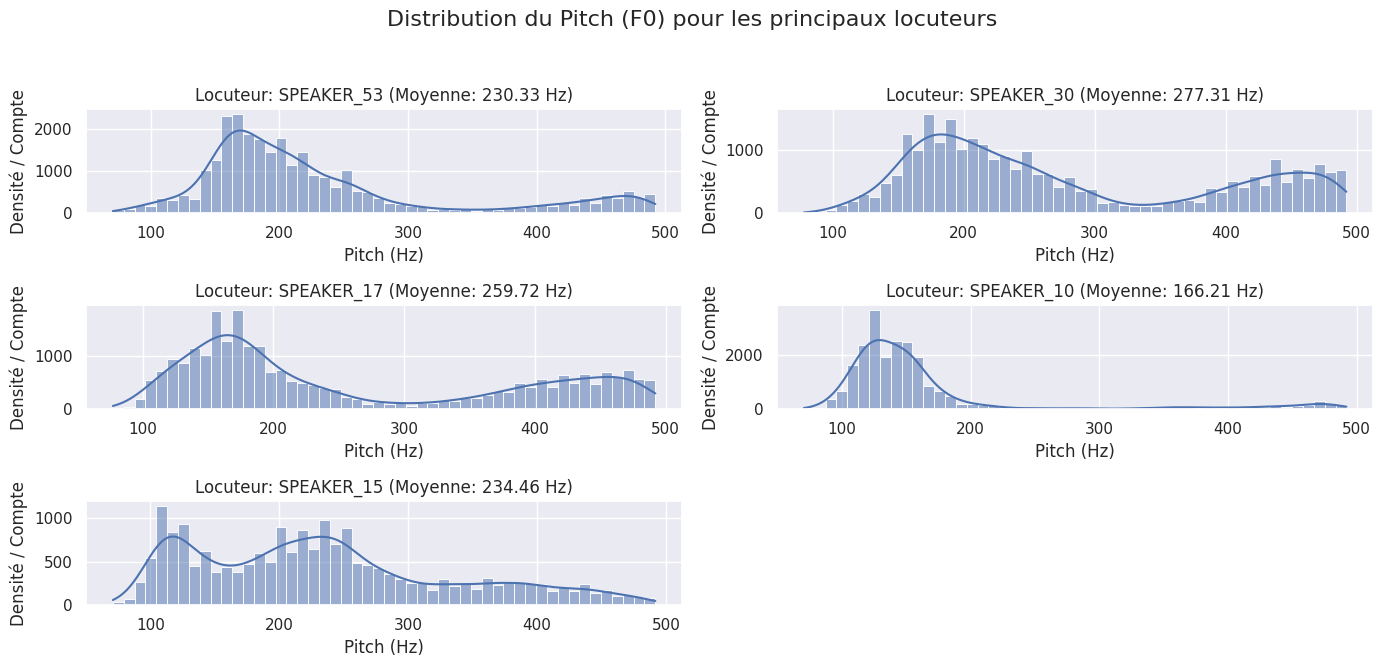

In [102]:
plt.figure(figsize=(14, 7))
plt.suptitle('Distribution du Pitch (F0) pour les principaux locuteurs', fontsize=16)

for i, speaker_label in enumerate(top_active_speakers):
    data = all_speaker_prosody_data[speaker_label]['pitches_raw']
    if data.size > 0:
        num_subplots = len(top_active_speakers)
        rows = (num_subplots + 1) // 2 # Calculer dynamiquement le nombre de lignes
        plt.subplot(rows, 2, i + 1)
        sns.histplot(data, kde=True, color=sns.color_palette("deep")[0], bins=50) # Utilisation de 'color'
        plt.title(f'Locuteur: {speaker_label} (Moyenne: {np.mean(data):.2f} Hz)')
        plt.xlabel('Pitch (Hz)')
        plt.ylabel('Densité / Compte')
    else:
        num_subplots = len(top_active_speakers)
        rows = (num_subplots + 1) // 2
        plt.subplot(rows, 2, i + 1)
        plt.text(0.5, 0.5, 'Pas de données de Pitch', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title(f'Locuteur: {speaker_label}')
        plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Exportation data to CSV

In [148]:
csv_filename_pitch_dist = "./output/pitch_distribution_data.csv"
pitch_data_for_export = []
for speaker_label in top_active_speakers:
    if speaker_label in all_speaker_prosody_data:
        raw_pitches = all_speaker_prosody_data[speaker_label]['pitches_raw']
        # Filter out NaN/inf values before adding to export list
        filtered_pitches = raw_pitches[np.isfinite(raw_pitches)]
        
        for pitch_val in filtered_pitches:
            pitch_data_for_export.append({'Speaker': speaker_label, 'Pitch_Hz': pitch_val})

df_pitch_distribution = pd.DataFrame(pitch_data_for_export)

df_pitch_distribution.to_csv(csv_filename_pitch_dist, index=False)
print(f"Pitch distribution data exported to '{csv_filename_pitch_dist}'")

Pitch distribution data exported to './output/pitch_distribution_data.csv'


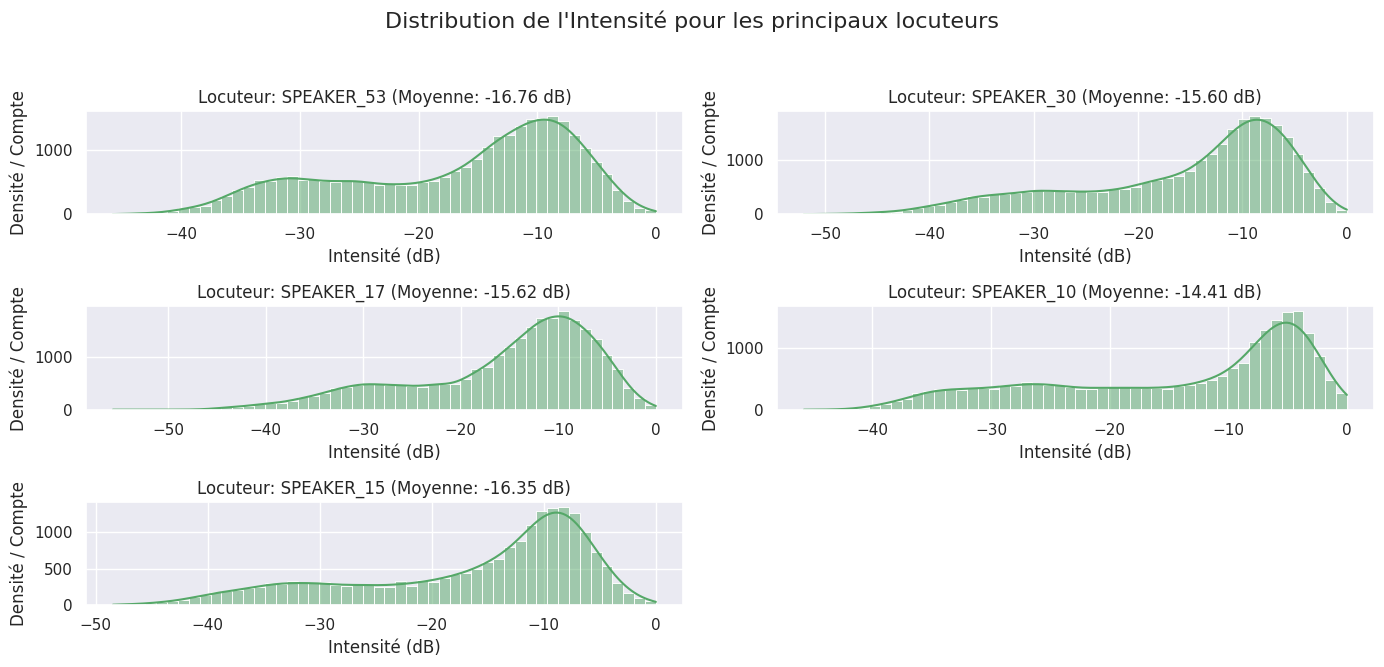

In [103]:
plt.figure(figsize=(14, 7))
plt.suptitle("Distribution de l'Intensité pour les principaux locuteurs", fontsize=16)

for i, speaker_label in enumerate(top_active_speakers):
    data = all_speaker_prosody_data[speaker_label]['intensities_raw']
    if data.size > 0:
        num_subplots = len(top_active_speakers)
        rows = (num_subplots + 1) // 2
        plt.subplot(rows, 2, i + 1)
        sns.histplot(data, kde=True, color=sns.color_palette("deep")[2], bins=50) # Utilisation de 'color'
        plt.title(f'Locuteur: {speaker_label} (Moyenne: {np.mean(data):.2f} dB)')
        plt.xlabel('Intensité (dB)')
        plt.ylabel('Densité / Compte')
    else:
        num_subplots = len(top_active_speakers)
        rows = (num_subplots + 1) // 2
        plt.subplot(rows, 2, i + 1)
        plt.text(0.5, 0.5, "Pas de données d'Intensité", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title(f'Locuteur: {speaker_label}')
        plt.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Exportation Data to CSV

In [149]:
csv_filename_intensity_dist = "./output/intensity_distribution_data.csv"
intensity_data_for_export = []

for speaker_label in top_active_speakers:
    if speaker_label in all_speaker_prosody_data:
        raw_intensities = all_speaker_prosody_data[speaker_label]['intensities_raw']
        # Filtrer les valeurs NaN/inf avant d'ajouter à la liste d'exportation
        filtered_intensities = raw_intensities[np.isfinite(raw_intensities)]
        
        for intensity_val in filtered_intensities:
            intensity_data_for_export.append({'Locuteur': speaker_label, 'Intensite_dB': intensity_val})
    else:
        print(f"Pas de données prosodiques trouvées pour {speaker_label}, saut de l'exportation pour ce locuteur.")

df_intensity_distribution = pd.DataFrame(intensity_data_for_export)

df_intensity_distribution.to_csv(csv_filename_intensity_dist, index=False)
print(f"Données de distribution de l'intensité exportées vers '{csv_filename_intensity_dist}'")


Données de distribution de l'intensité exportées vers './output/intensity_distribution_data.csv'



--- Prosodic Contours with Long Segment Highlights (> 20 seconds) ---


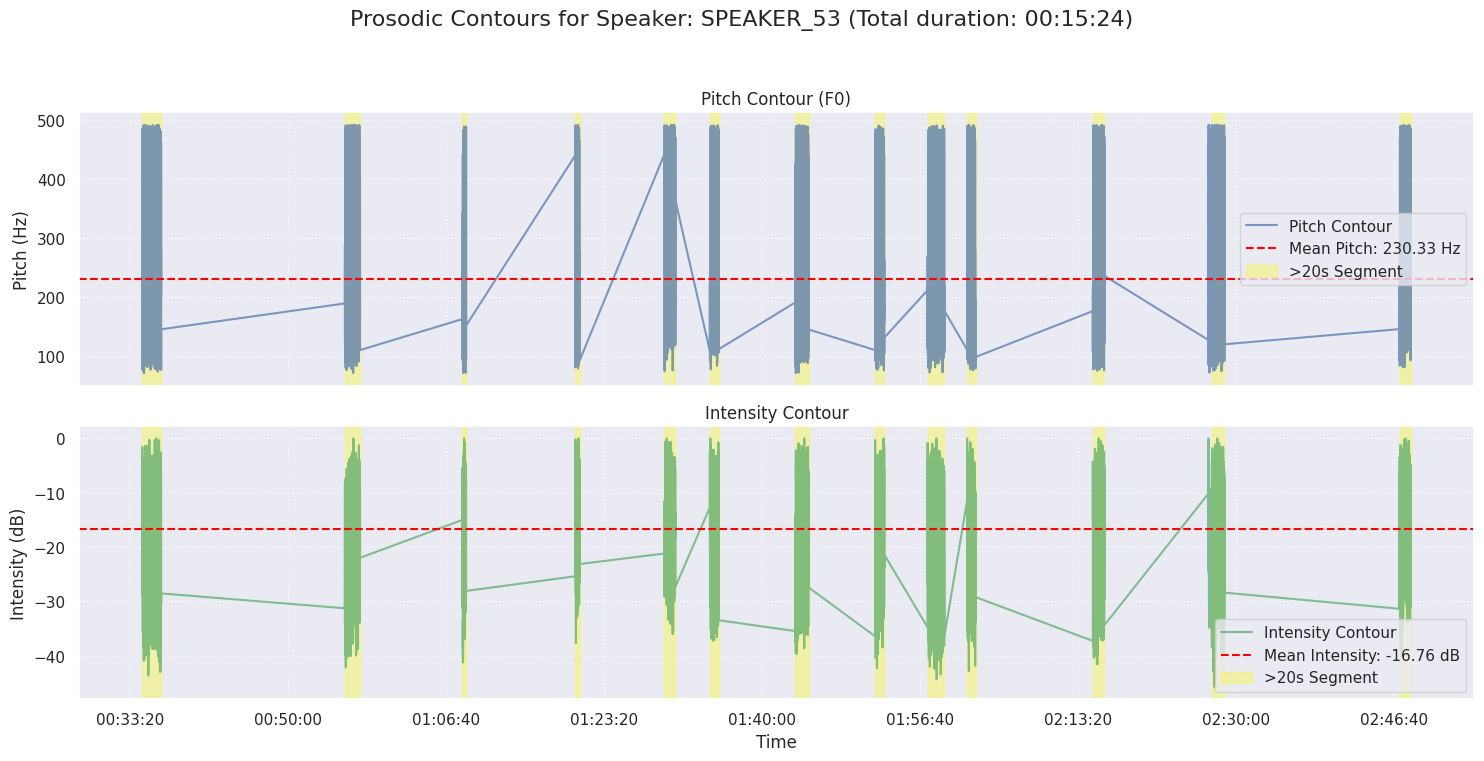

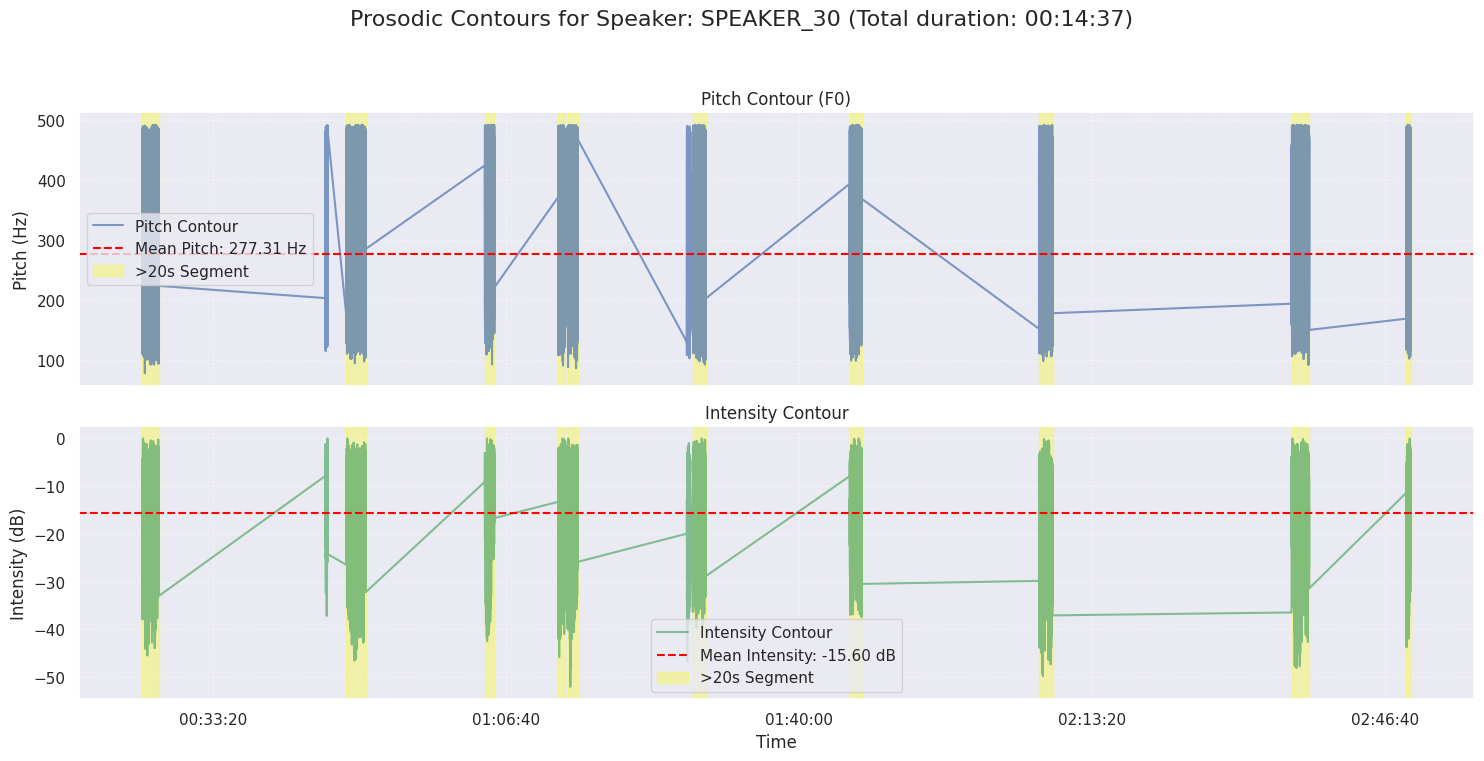

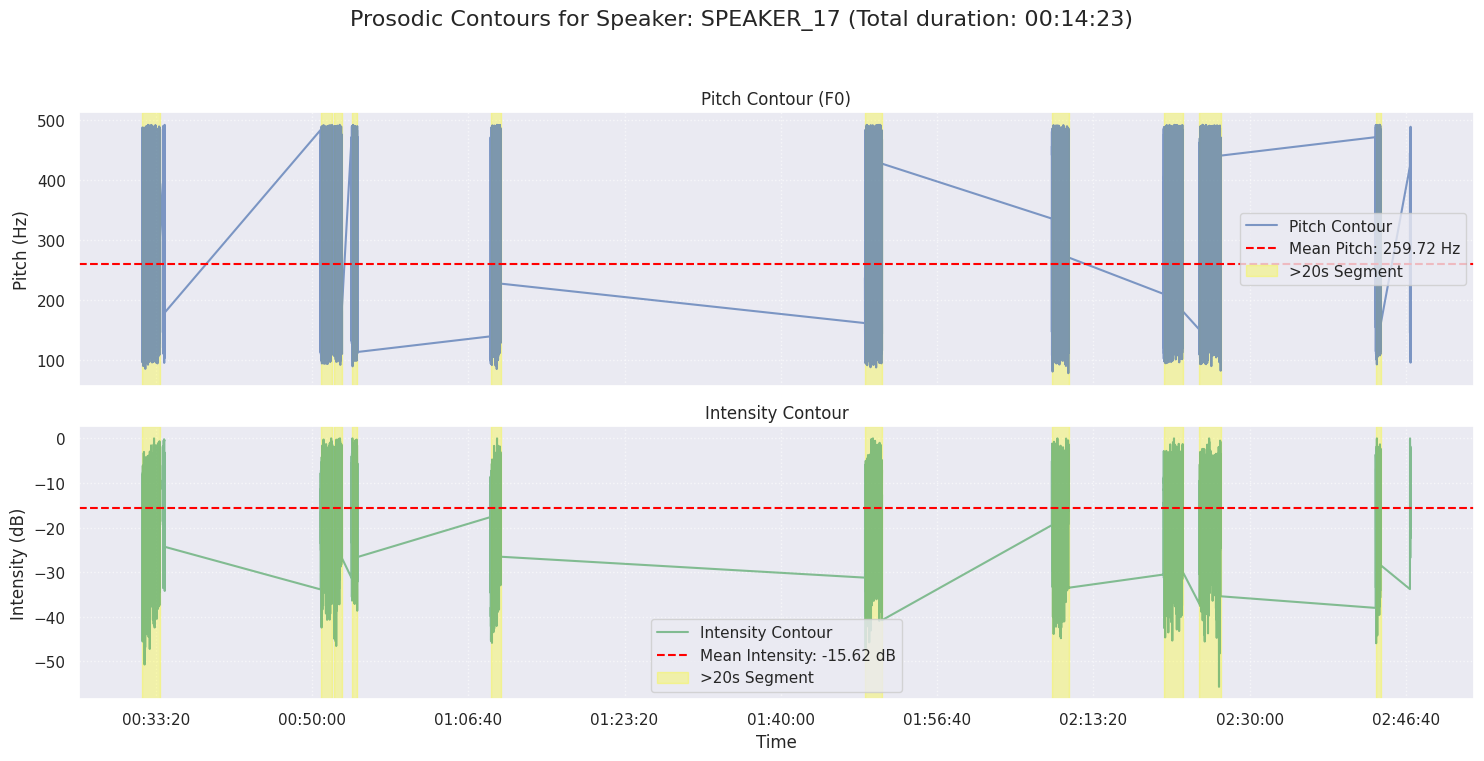

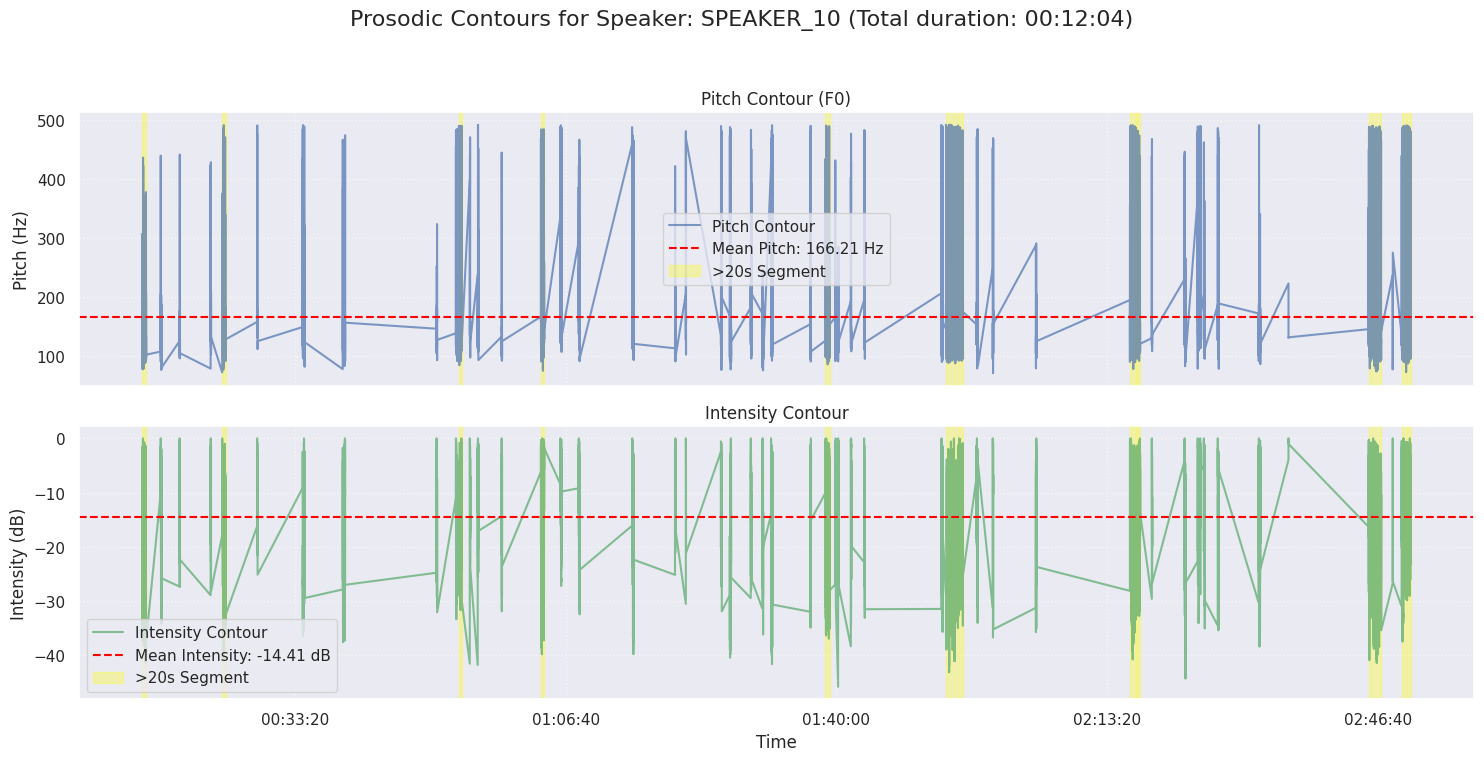

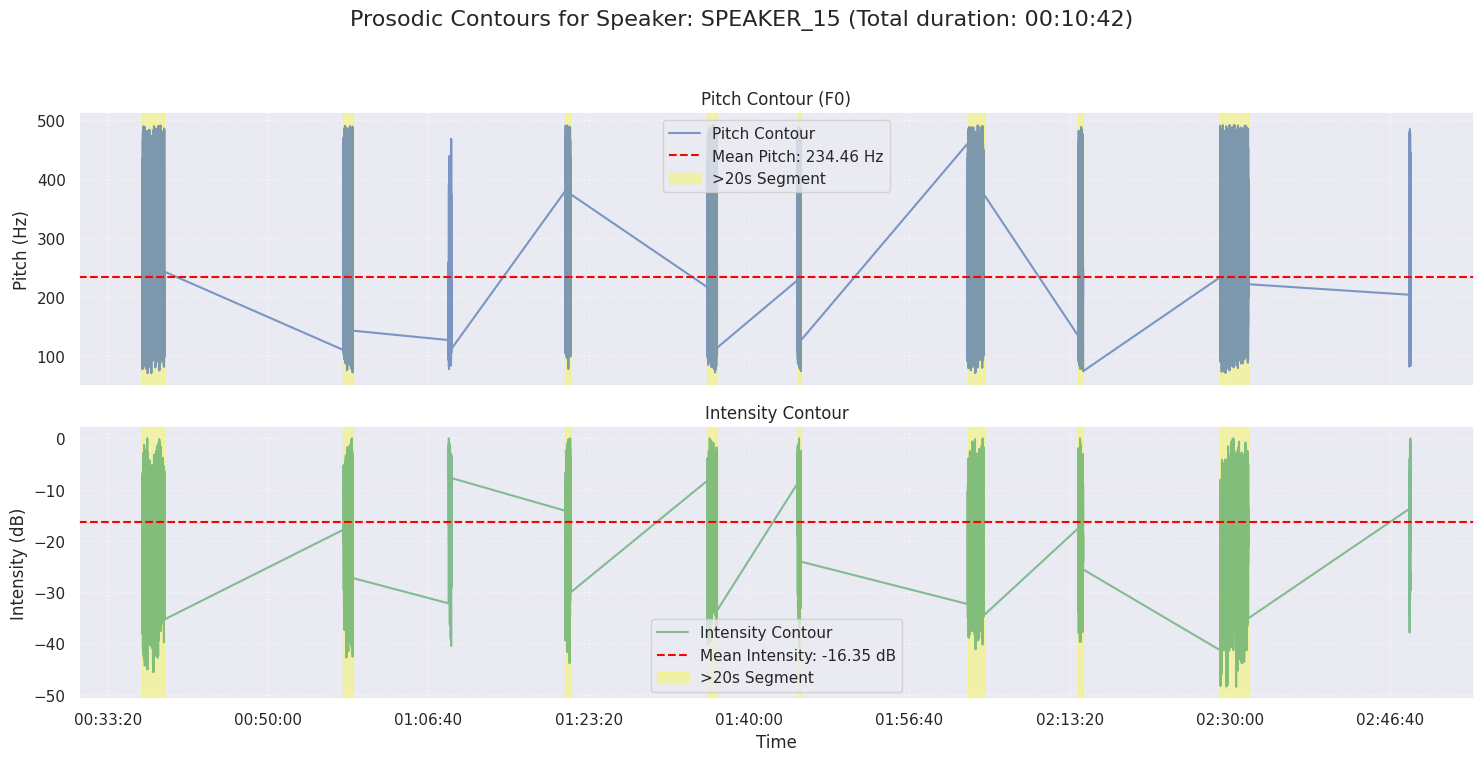

In [104]:
print("\n--- Prosodic Contours with Long Segment Highlights (> 20 seconds) ---")

# Function to format seconds into hh:mm:ss
def format_time(x, pos):
    hours = int(x // 3600)
    minutes = int((x % 3600) // 60)
    seconds = int(x % 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

time_formatter = FuncFormatter(format_time)


for i, speaker_label in enumerate(top_active_speakers):
    data_pitch = all_speaker_prosody_data[speaker_label]['pitches_contour']
    times_pitch = all_speaker_prosody_data[speaker_label]['pitches_times']
    data_intensity = all_speaker_prosody_data[speaker_label]['intensities_contour']
    times_intensity = all_speaker_prosody_data[speaker_label]['intensities_times']

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    # Convert total duration to hh:mm:ss for the title
    total_duration_seconds = speaker_durations[speaker_label]
    td_hours = int(total_duration_seconds // 3600)
    td_minutes = int((total_duration_seconds % 3600) // 60)
    td_seconds = int(total_duration_seconds % 60)
    formatted_total_duration = f"{td_hours:02}:{td_minutes:02}:{td_seconds:02}"

    fig.suptitle(f'Prosodic Contours for Speaker: {speaker_label} (Total duration: {formatted_total_duration})', fontsize=16)

    # Récupérer les segments longs pour ce locuteur (filtrés à > 20 secondes)
    long_segments_for_speaker = [
        s for s in speaker_segments[speaker_label] if s.duration >= 20.0
    ]

    # Contour de Pitch
    if data_pitch.size > 0:
        ax1.plot(times_pitch, data_pitch, color=sns.color_palette("deep")[0], alpha=0.7, label='Pitch Contour')
        ax1.set_ylabel('Pitch (Hz)')
        ax1.set_title('Pitch Contour (F0)')
        ax1.grid(True, linestyle=':', alpha=0.6)
        ax1.axhline(np.mean(data_pitch), color='red', linestyle='--', label=f'Mean Pitch: {np.mean(data_pitch):.2f} Hz')

        # Ajout des zones ombragées pour les segments longs de Pitch
        for seg in long_segments_for_speaker:
            ax1.axvspan(seg.start, seg.end, color='yellow', alpha=0.3, label='>20s Segment' if seg == long_segments_for_speaker[0] else "")
        ax1.legend()
    else:
        ax1.text(0.5, 0.5, 'No Pitch Data', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
        ax1.axis('off')

    # Contour d'Intensité
    if data_intensity.size > 0:
        ax2.plot(times_intensity, data_intensity, color=sns.color_palette("deep")[2], alpha=0.7, label='Intensity Contour')
        ax2.set_ylabel('Intensity (dB)')
        ax2.set_title('Intensity Contour')
        ax2.set_xlabel('Time') # Remove " (seconds)" as it will be formatted
        ax2.grid(True, linestyle=':', alpha=0.6)
        ax2.axhline(np.mean(data_intensity), color='red', linestyle='--', label=f'Mean Intensity: {np.mean(data_intensity):.2f} dB')

        # Ajout des zones ombragées pour les segments longs d'Intensité
        for seg in long_segments_for_speaker:
            ax2.axvspan(seg.start, seg.end, color='yellow', alpha=0.3, label='>20s Segment' if seg == long_segments_for_speaker[0] else "")
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'No Intensity Data', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
        ax2.axis('off')

    # Apply the custom time formatter to the x-axis for both subplots
    ax2.xaxis.set_major_formatter(time_formatter)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Export to CSV

In [150]:
csv_filename_intensity_contour = "./output/prosodic_contours_intensity.csv"
all_intensity_contour_data_for_export = []

for speaker_label in top_active_speakers:
    if speaker_label in all_speaker_prosody_data:
        times = all_speaker_prosody_data[speaker_label]['intensities_times']
        intensities = all_speaker_prosody_data[speaker_label]['intensities_contour']

        # Filtrer les valeurs NaN de l'intensité pour l'exportation
        valid_indices = ~np.isnan(intensities)
        
        for t, i_val in zip(times[valid_indices], intensities[valid_indices]):
            all_intensity_contour_data_for_export.append({'Locuteur': speaker_label, 'Temps_s': t, 'Intensite_dB': i_val})
    else:
        print(f"Pas de données d'intensité trouvées pour {speaker_label}, saut de l'exportation du contour d'intensité.")

df_intensity_contour = pd.DataFrame(all_intensity_contour_data_for_export)

df_intensity_contour.to_csv(csv_filename_intensity_contour, index=False)
print(f"Données de contour d'intensité exportées vers '{csv_filename_intensity_contour}'")

Données de contour d'intensité exportées vers './output/prosodic_contours_intensity.csv'


In [151]:
csv_filename_pitch_contour = "./output/prosodic_contours_pitch.csv"
all_pitch_contour_data_for_export = []

for speaker_label in top_active_speakers:
    if speaker_label in all_speaker_prosody_data:
        times = all_speaker_prosody_data[speaker_label]['pitches_times']
        pitches = all_speaker_prosody_data[speaker_label]['pitches_contour']

        # Filtrer les valeurs NaN/0 de pitch pour l'exportation
        valid_indices = ~np.isnan(pitches) & (pitches > 0)
        
        for t, p in zip(times[valid_indices], pitches[valid_indices]):
            all_pitch_contour_data_for_export.append({'Locuteur': speaker_label, 'Temps_s': t, 'Pitch_Hz': p})
    else:
        print(f"Pas de données de pitch trouvées pour {speaker_label}, saut de l'exportation du contour de pitch.")


df_pitch_contour = pd.DataFrame(all_pitch_contour_data_for_export)

df_pitch_contour.to_csv(csv_filename_pitch_contour, index=False)
print(f"Données de contour de pitch exportées vers '{csv_filename_pitch_contour}'")

Données de contour de pitch exportées vers './output/prosodic_contours_pitch.csv'


In [105]:
# --- 8. PARTIE: Affichage des temps de parole détaillés (tous segments) ---
print("\n--- Detailed Speaking Times per Speaker (All segments) ---")
# On peut changer 'top_active_speakers' par 'speaker_segments.keys()' pour afficher tous les locuteurs
speakers_to_show_timeline_all = speaker_segments.keys() 

for speaker_label in speakers_to_show_timeline_all:
    # Convertir la durée totale du locuteur en hh:mm:ss
    total_duration_seconds = speaker_durations[speaker_label]
    td_hours = int(total_duration_seconds // 3600)
    td_minutes = int((total_duration_seconds % 3600) // 60)
    td_seconds = int(total_duration_seconds % 60)
    formatted_total_duration = f"{td_hours:02}:{td_minutes:02}:{td_seconds:02}"

    print(f"\nTimeline for {speaker_label} (Total duration: {formatted_total_duration}):")
    
    sorted_segments = sorted(speaker_segments[speaker_label], key=lambda s: s.start)
    for i, segment in enumerate(sorted_segments):
        # Convertir le temps de début en hh:mm:ss
        start_seconds_raw = int(segment.start)
        s_hours = start_seconds_raw // 3600
        s_minutes = (start_seconds_raw % 3600) // 60
        s_seconds = start_seconds_raw % 60
        formatted_start = f"{s_hours:02}:{s_minutes:02}:{s_seconds:02}"

        # Convertir le temps de fin en hh:mm:ss
        end_seconds_raw = int(segment.end)
        e_hours = end_seconds_raw // 3600
        e_minutes = (end_seconds_raw % 3600) // 60
        e_seconds = end_seconds_raw % 60
        formatted_end = f"{e_hours:02}:{e_minutes:02}:{e_seconds:02}"

        # Convertir la durée du segment en hh:mm:ss
        seg_duration_seconds = segment.duration
        sd_hours = int(seg_duration_seconds // 3600)
        sd_minutes = int((seg_duration_seconds % 3600) // 60)
        sd_seconds = int(seg_duration_seconds % 60)
        formatted_segment_duration = f"{sd_hours:02}:{sd_minutes:02}:{sd_seconds:02}"
        
        print(f"  - Segment {i+1}: [{formatted_start} - {formatted_end}] (Duration: {formatted_segment_duration})")


--- Detailed Speaking Times per Speaker (All segments) ---

Timeline for SPEAKER_10 (Total duration: 00:12:04):
  - Segment 1: [00:14:34 - 00:15:02] (Duration: 00:00:28)
  - Segment 2: [00:16:50 - 00:16:57] (Duration: 00:00:06)
  - Segment 3: [00:19:08 - 00:19:13] (Duration: 00:00:04)
  - Segment 4: [00:22:59 - 00:23:02] (Duration: 00:00:03)
  - Segment 5: [00:24:24 - 00:24:49] (Duration: 00:00:24)
  - Segment 6: [00:28:42 - 00:28:45] (Duration: 00:00:03)
  - Segment 7: [00:34:18 - 00:34:33] (Duration: 00:00:14)
  - Segment 8: [00:39:14 - 00:39:32] (Duration: 00:00:17)
  - Segment 9: [00:50:46 - 00:50:51] (Duration: 00:00:05)
  - Segment 10: [00:53:10 - 00:53:21] (Duration: 00:00:11)
  - Segment 11: [00:53:32 - 00:53:53] (Duration: 00:00:21)
  - Segment 12: [00:54:52 - 00:54:56] (Duration: 00:00:03)
  - Segment 13: [00:55:51 - 00:55:56] (Duration: 00:00:05)
  - Segment 14: [00:58:48 - 00:58:51] (Duration: 00:00:03)
  - Segment 15: [01:03:37 - 01:04:01] (Duration: 00:00:23)
  - Segment

In [106]:
# --- 9. PARTIE: Affichage des temps de parole des segments > 20 secondes ---
print("\n--- Long Speech Segments (more than 20 seconds) per Speaker ---")
# On peut changer 'top_active_speakers' par 'speaker_segments.keys()' pour afficher tous les locuteurs
speakers_to_show_timeline_long = speaker_segments.keys() 

for speaker_label in speakers_to_show_timeline_long:
    sorted_segments = sorted(speaker_segments[speaker_label], key=lambda s: s.start)
    long_segments_found = False

    # Convertir la durée totale du locuteur en hh:mm:ss
    total_duration_seconds = speaker_durations[speaker_label]
    td_hours = int(total_duration_seconds // 3600)
    td_minutes = int((total_duration_seconds % 3600) // 60)
    td_seconds = int(total_duration_seconds % 60)
    formatted_total_duration = f"{td_hours:02}:{td_minutes:02}:{td_seconds:02}"

    for i, segment in enumerate(sorted_segments):
        if segment.duration >= 20.0:
            if not long_segments_found:
                print(f"\nTimeline for {speaker_label} (Total duration: {formatted_total_duration}):")
                long_segments_found = True
            
            # Convertir le temps de début en hh:mm:ss
            start_seconds_raw = int(segment.start)
            s_hours = start_seconds_raw // 3600
            s_minutes = (start_seconds_raw % 3600) // 60
            s_seconds = start_seconds_raw % 60
            formatted_start = f"{s_hours:02}:{s_minutes:02}:{s_seconds:02}"

            # Convertir le temps de fin en hh:mm:ss
            end_seconds_raw = int(segment.end)
            e_hours = end_seconds_raw // 3600
            e_minutes = (end_seconds_raw % 3600) // 60
            e_seconds = end_seconds_raw % 60
            formatted_end = f"{e_hours:02}:{e_minutes:02}:{e_seconds:02}"

            # Convertir la durée du segment en hh:mm:ss
            seg_duration_seconds = segment.duration
            sd_hours = int(seg_duration_seconds // 3600)
            sd_minutes = int((seg_duration_seconds % 3600) // 60)
            sd_seconds = int(seg_duration_seconds % 60)
            formatted_segment_duration = f"{sd_hours:02}:{sd_minutes:02}:{sd_seconds:02}"
            
            print(f"  - Segment: [{formatted_start} - {formatted_end}] (Duration: {formatted_segment_duration})")
    if not long_segments_found:
        print(f"\nNo segments longer than 20 seconds found for {speaker_label}.")


--- Long Speech Segments (more than 20 seconds) per Speaker ---

Timeline for SPEAKER_10 (Total duration: 00:12:04):
  - Segment: [00:14:34 - 00:15:02] (Duration: 00:00:28)
  - Segment: [00:24:24 - 00:24:49] (Duration: 00:00:24)
  - Segment: [00:53:32 - 00:53:53] (Duration: 00:00:21)
  - Segment: [01:03:37 - 01:04:01] (Duration: 00:00:23)
  - Segment: [01:38:36 - 01:39:09] (Duration: 00:00:33)
  - Segment: [01:53:28 - 01:54:46] (Duration: 00:01:17)
  - Segment: [01:54:57 - 01:55:34] (Duration: 00:00:37)
  - Segment: [02:16:06 - 02:16:52] (Duration: 00:00:45)
  - Segment: [02:17:02 - 02:17:22] (Duration: 00:00:20)
  - Segment: [02:45:30 - 02:47:02] (Duration: 00:01:32)
  - Segment: [02:49:33 - 02:49:53] (Duration: 00:00:20)
  - Segment: [02:50:05 - 02:50:39] (Duration: 00:00:34)

Timeline for SPEAKER_09 (Total duration: 00:01:13):
  - Segment: [01:53:05 - 01:53:28] (Duration: 00:00:22)

Timeline for SPEAKER_32 (Total duration: 00:01:52):
  - Segment: [00:15:08 - 00:16:49] (Duration: 00

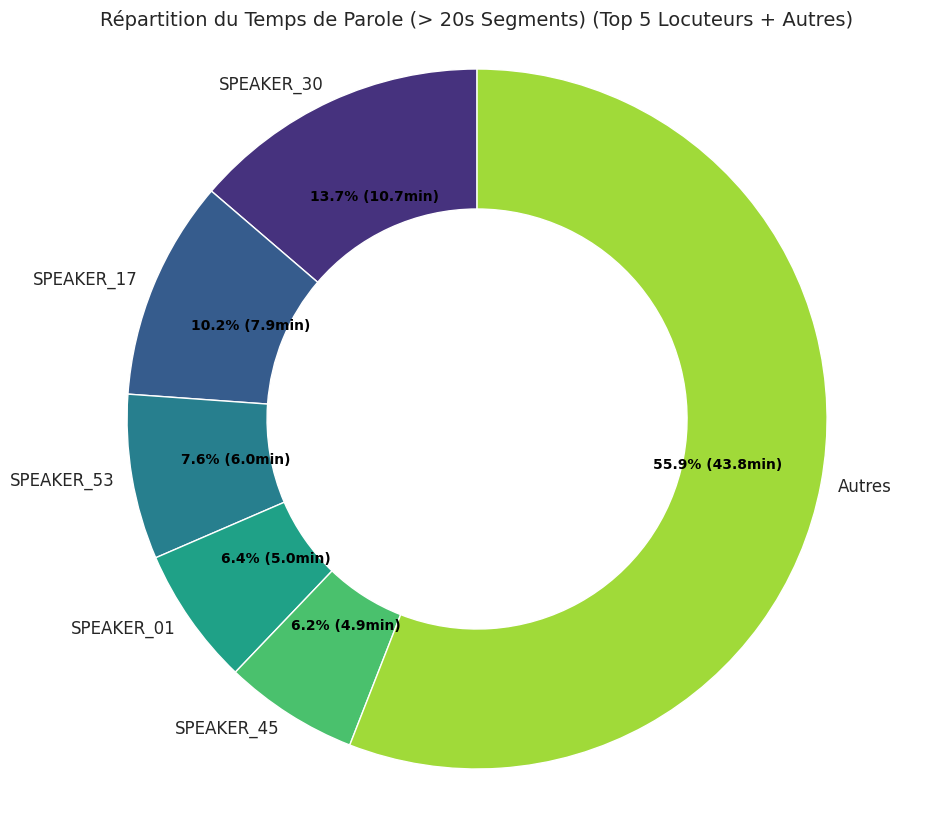


--- Répartition détaillée du temps de parole (Segments > 20 secondes) ---
SPEAKER_30: 643.87 secondes (10.73 minutes)
SPEAKER_17: 476.67 secondes (7.94 minutes)
SPEAKER_53: 357.73 secondes (5.96 minutes)
SPEAKER_01: 299.62 secondes (4.99 minutes)
SPEAKER_45: 291.36 secondes (4.86 minutes)
Autres: 2625.50 secondes (43.76 minutes)
Temps total de parole affiché (Segments > 20s): 4694.74 secondes (78.25 minutes)


In [107]:
speaker_durations_filtered = defaultdict(float)
for segment, _, label in diarization.itertracks(yield_label=True):
    duration = segment.duration
    if duration >= 20.0: # Condition: segment doit durer au moins 20 secondes
        speaker_durations_filtered[label] += duration

if not speaker_durations_filtered:
    print("\nAucun locuteur n'a de prise de parole de plus de 20 secondes pour créer le camembert.")
else:
    # Trier les locuteurs par durée de parole décroissante (basé sur les segments filtrés)
    sorted_speakers_filtered = sorted(speaker_durations_filtered.items(), key=lambda item: item[1], reverse=True)

    # Prendre les 5 premiers locuteurs filtrés
    top_5_speakers_filtered = sorted_speakers_filtered[:5]

    # Calculer la durée pour la catégorie "Autres" parmi les segments filtrés
    other_duration_filtered = 0
    for i in range(5, len(sorted_speakers_filtered)):
        other_duration_filtered += sorted_speakers_filtered[i][1]

    # Préparer les données pour le camembert
    labels_pie = [speaker for speaker, _ in top_5_speakers_filtered]
    sizes_pie = [duration for _, duration in top_5_speakers_filtered]

    # Ajouter "Autres" si nécessaire
    if other_duration_filtered > 0:
        labels_pie.append("Autres")
        sizes_pie.append(other_duration_filtered)

    # Calculer la durée totale en secondes pour le calcul des minutes dans le camembert
    total_duration_seconds_filtered = sum(sizes_pie)

    # Créer le camembert
    plt.figure(figsize=(12, 10)) # Augmenter la taille du graphique

    sns.set_palette("viridis")
    
    wedges, texts, autotexts = plt.pie(
        sizes_pie,
        labels=labels_pie,
        autopct=lambda p: f'{p:.1f}% ({p/100 * total_duration_seconds_filtered / 60:.1f}min)',
        startangle=90,
        pctdistance=0.70, # Rapproche le pourcentage et les minutes du centre du donut
        labeldistance=1.05, # Éloigne légèrement les labels des tranches
        wedgeprops=dict(width=0.4, edgecolor='w')
    )

    # Améliorer la lisibilité du texte de pourcentage
    for autotext in autotexts:
        autotext.set_color('black') # Changer en noir pour un meilleur contraste
        autotext.set_weight('bold')
        autotext.set_fontsize(10)

    # Améliorer la lisibilité du texte des labels
    for text in texts:
        text.set_fontsize(12) # Ajuster la taille de la police pour les labels

    plt.title("Répartition du Temps de Parole (> 20s Segments) (Top 5 Locuteurs + Autres)", fontsize=14)
    plt.axis('equal') # Assure que le camembert est un cercle parfait
    plt.show()

    print("\n--- Répartition détaillée du temps de parole (Segments > 20 secondes) ---")
    for speaker, duration in top_5_speakers_filtered:
        print(f"{speaker}: {duration:.2f} secondes ({duration/60:.2f} minutes)")
    if other_duration_filtered > 0:
        print(f"Autres: {other_duration_filtered:.2f} secondes ({other_duration_filtered/60:.2f} minutes)")
    print(f"Temps total de parole affiché (Segments > 20s): {total_duration_seconds_filtered:.2f} secondes ({total_duration_seconds_filtered/60:.2f} minutes)")


In [108]:
output_rttm_path = "./output/pyannote_diarization_output.rttm"
file_id = "parlementtary_session"  # Identifier unique pour le fichier audio, peut être le nom du fichier sans extension

try:
    with open(output_rttm_path, 'w') as f:
        # Itérer sur tous les segments et leurs labels dans l'objet Diarization
        # .itertracks(yield_label=True) renvoie (segment, id_piste, label_locuteur)
        for segment, track_id, speaker_label in diarization.itertracks(yield_label=True):
            # Le format RTTM est :
            # SPEAKER <file_id> <channel> <start_time> <duration> <NA> <NA> <speaker_id> <NA> <NA>
            # <channel> est généralement 1 pour un audio mono.
            # Les champs <NA> sont des placeholders pour des informations non utilisées ici.

            line = (
                f"SPEAKER {file_id} 1 {segment.start:.3f} {segment.duration:.3f} "
                f"<NA> <NA> {speaker_label} <NA> <NA>\n"
            )
            f.write(line)

    print(f"\nLe fichier RTTM de la diarisation Pyannote a été généré avec succès ici : {output_rttm_path}")
    print(f"Vous pouvez maintenant utiliser '{output_rttm_path}' pour l'évaluation avec un fichier de référence RTTM.")

except Exception as e:
    print(f"\nUne erreur est survenue lors de la génération du fichier RTTM : {e}")


Le fichier RTTM de la diarisation Pyannote a été généré avec succès ici : ./output/pyannote_diarization_output.rttm
Vous pouvez maintenant utiliser './output/pyannote_diarization_output.rttm' pour l'évaluation avec un fichier de référence RTTM.


In [109]:
# Charger le RTTM de référence
reference_rttm = load_rttm(f"./output/reference_from_xml.rttm")

pyannote_rttm = load_rttm(f"./output/pyannote_diarization_output.rttm")
der = DiarizationErrorRate()
der_value = der(reference_rttm, pyannote_rttm)
print(f"DER: {der_value:.2%}")

# Résumé global
print("Overall DER:", der)

/home/infres/mtoussi-24/Assembl-IA/.venv/lib/python3.12/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


DER: 328.01%
Overall DER:       diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                           %                       %                       %                                 %                   %
item                                                                                                                              
None                  328.01 2500.00  981.34   39.25     6681.70      267.27           675.77            27.03    842.89     33.72
TOTAL                 328.01 2500.00  981.34   39.25     6681.70      267.27           675.77            27.03    842.89     33.72


In [110]:
print("\n--- Tableau Récapitulatif des Caractéristiques Prosodiques par Locuteur ---")

prosody_summary = []
for speaker_label in top_active_speakers:
    data = all_speaker_prosody_data[speaker_label]
    pitches = data['pitches_contour']
    intensities = data['intensities_contour']

    mean_pitch = np.mean(pitches) if pitches.size > 0 else np.nan
    std_pitch = np.std(pitches) if pitches.size > 0 else np.nan
    min_pitch = np.min(pitches) if pitches.size > 0 else np.nan
    max_pitch = np.max(pitches) if pitches.size > 0 else np.nan

    mean_intensity = np.mean(intensities) if intensities.size > 0 else np.nan
    std_intensity = np.std(intensities) if intensities.size > 0 else np.nan
    min_intensity = np.min(intensities) if intensities.size > 0 else np.nan
    max_intensity = np.max(intensities) if intensities.size > 0 else np.nan

    total_time_seconds = speaker_durations.get(speaker_label, 0)

    prosody_summary.append({
        'Locuteur': speaker_label,
        'Temps_Parole_Min': total_time_seconds / 60,
        'Pitch_Moyen_Hz': mean_pitch,
        'Pitch_Std_Hz': std_pitch,
        'Pitch_Min_Hz': min_pitch,
        'Pitch_Max_Hz': max_pitch,
        'Intensite_Moy_dB': mean_intensity,
        'Intensite_Std_dB': std_intensity,
        'Intensite_Min_dB': min_intensity,
        'Intensite_Max_dB': max_intensity
    })

df_summary = pd.DataFrame(prosody_summary)
df_summary = df_summary.round(2) # Arrondir pour une meilleure lisibilité
print(df_summary.to_string())


--- Tableau Récapitulatif des Caractéristiques Prosodiques par Locuteur ---
     Locuteur  Temps_Parole_Min  Pitch_Moyen_Hz  Pitch_Std_Hz  Pitch_Min_Hz  Pitch_Max_Hz  Intensite_Moy_dB  Intensite_Std_dB  Intensite_Min_dB  Intensite_Max_dB
0  SPEAKER_53             15.40      230.330002     99.629997     70.599998    492.119995            -16.76              9.71        -45.759998               0.0
1  SPEAKER_30             14.62      277.309998    114.599998     78.040001    492.179993            -15.60             10.13        -52.020000               0.0
2  SPEAKER_17             14.39      259.720001    126.540001     77.139999    492.179993            -15.62              9.40        -55.689999               0.0
3  SPEAKER_10             12.08      166.210007     88.629997     70.410004    492.019989            -14.41             10.87        -45.770000               0.0
4  SPEAKER_15             10.71      234.460007    100.080002     70.879997    491.790009            -16.35      

In [111]:
pitch_data_for_plot = []
intensity_data_for_plot = []
# On ne met plus speaker_labels_for_plot en tant que liste séparée
# car pandas DataFrame gère mieux la correspondance des données.

for speaker_label in top_active_speakers:
    data = all_speaker_prosody_data[speaker_label]
    pitches = data['pitches_contour']
    intensities = data['intensities_contour']

    if pitches.size > 0 and np.isfinite(pitches).any():
        for p in pitches:
            pitch_data_for_plot.append({'Locuteur': speaker_label, 'Pitch (Hz)': p})
    
    if intensities.size > 0 and np.isfinite(intensities).any():
        for i in intensities:
            intensity_data_for_plot.append({'Locuteur': speaker_label, 'Intensité (dB)': i})


plot_df_pitch = pd.DataFrame(pitch_data_for_plot)
plot_df_intensity = pd.DataFrame(intensity_data_for_plot)

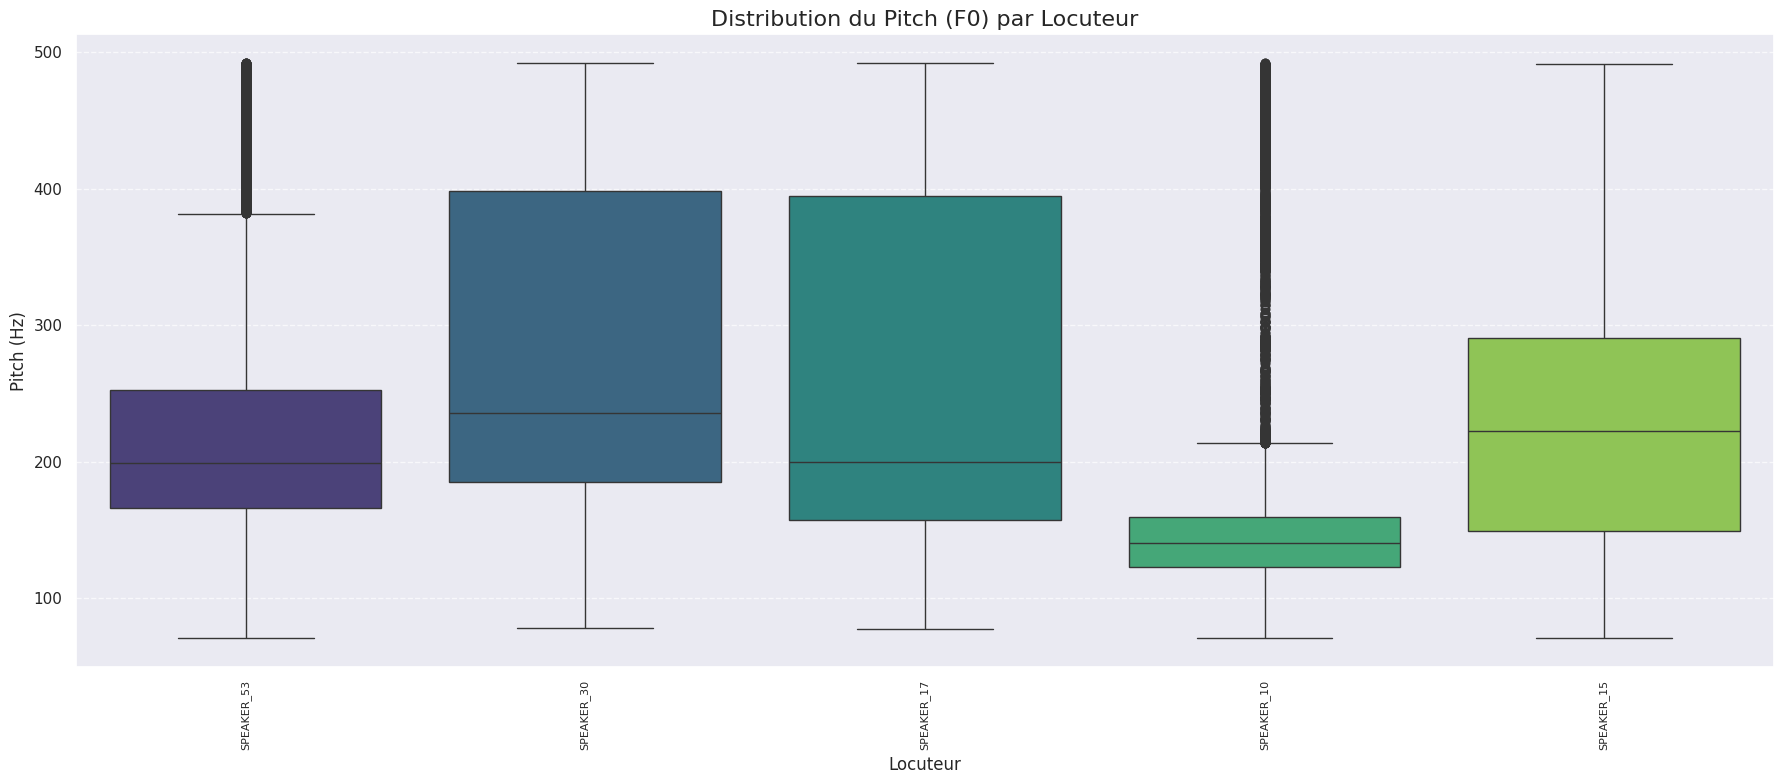

In [112]:
plt.figure(figsize=(18, 8))
sns.boxplot(x='Locuteur', y='Pitch (Hz)', hue='Locuteur', data=plot_df_pitch, palette='viridis', legend=False)
plt.title('Distribution du Pitch (F0) par Locuteur', fontsize=16)
plt.xlabel('Locuteur', fontsize=12)
plt.ylabel('Pitch (Hz)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

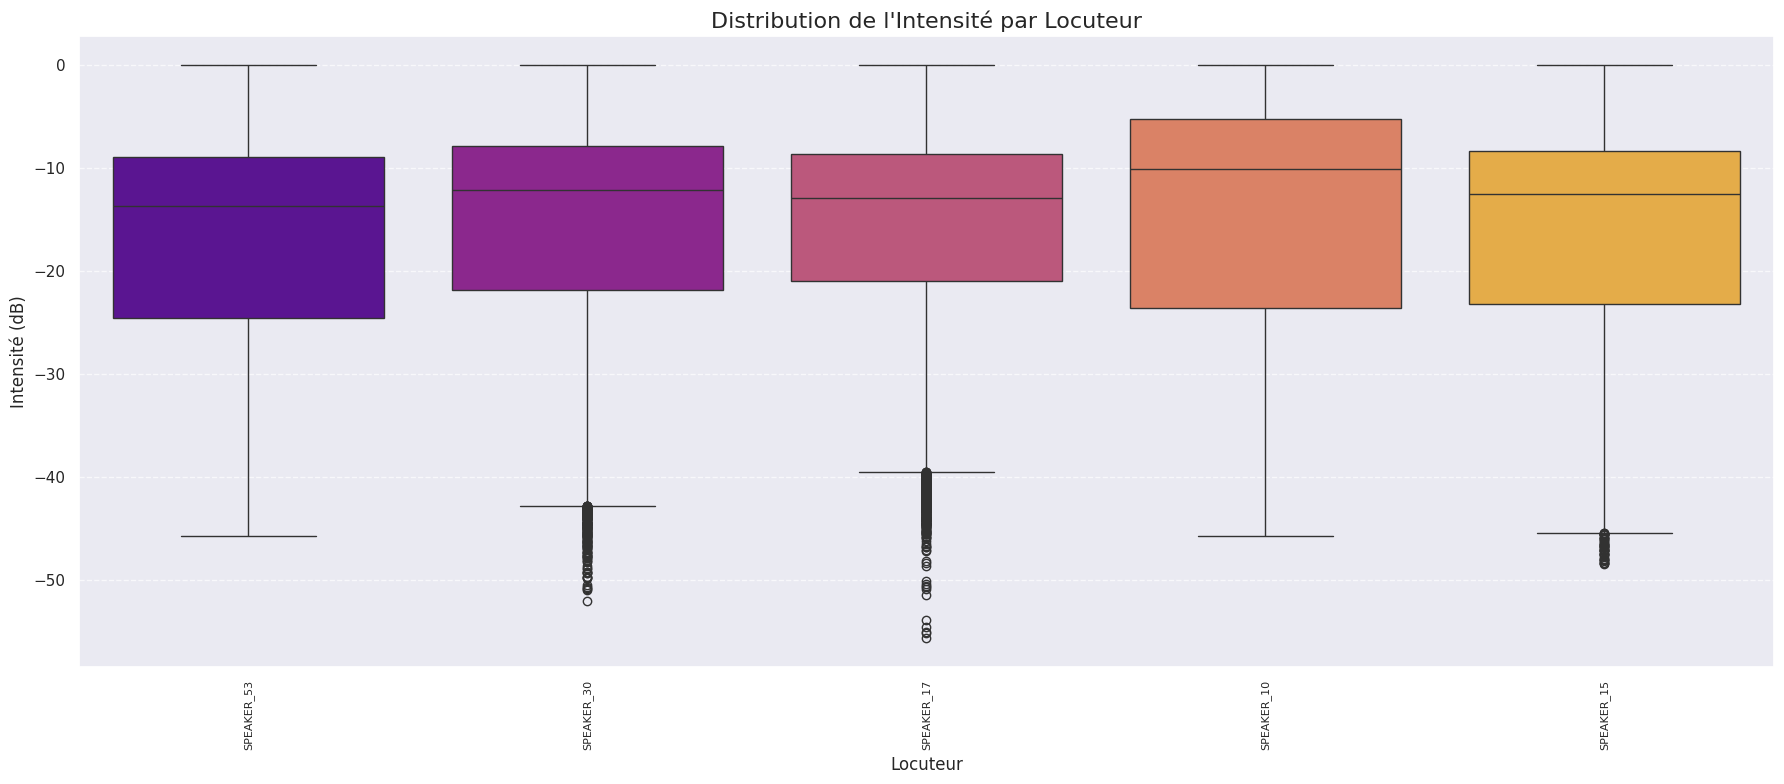

In [113]:
plt.figure(figsize=(18, 8))
sns.boxplot(x='Locuteur', y='Intensité (dB)', hue='Locuteur', data=plot_df_intensity, palette='plasma', legend=False)
plt.title("Distribution de l'Intensité par Locuteur", fontsize=16)
plt.xlabel('Locuteur', fontsize=12)
plt.ylabel('Intensité (dB)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [114]:
scatter_data = []
for speaker_label in top_active_speakers:
    data = all_speaker_prosody_data[speaker_label]
    mean_pitch = np.mean(data['pitches_contour']) if data['pitches_contour'].size > 0 else np.nan
    mean_intensity = np.mean(data['intensities_contour']) if data['intensities_contour'].size > 0 else np.nan

    if not np.isnan(mean_pitch) and not np.isnan(mean_intensity):
        scatter_data.append({
            'Locuteur': speaker_label,
            'Pitch_Moyen_Hz': mean_pitch,
            'Intensite_Moy_dB': mean_intensity
        })

scatter_df = pd.DataFrame(scatter_data)

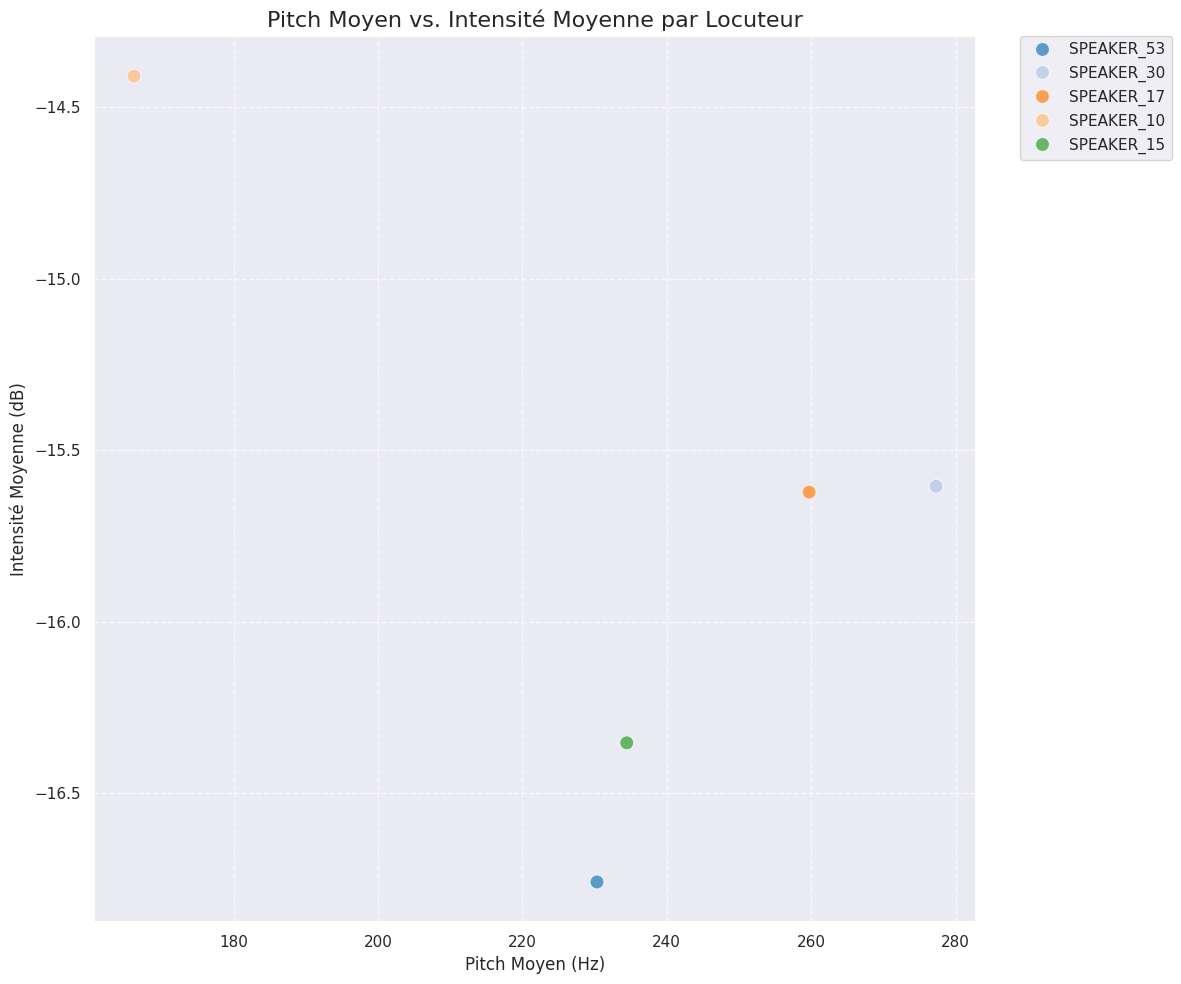

In [115]:
plt.figure(figsize=(12, 10))
# Pour le scatter plot, 'hue' est déjà utilisé pour les locuteurs
sns.scatterplot(x='Pitch_Moyen_Hz', y='Intensite_Moy_dB', hue='Locuteur', data=scatter_df, s=100, alpha=0.7, palette='tab20')

plt.title('Pitch Moyen vs. Intensité Moyenne par Locuteur', fontsize=16)
plt.xlabel('Pitch Moyen (Hz)', fontsize=12)
plt.ylabel('Intensité Moyenne (dB)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

### Timeline des Prises de Paroles

In [116]:
plot_data = []
speaker_to_y_index = {} # Pour mapper les noms des locuteurs à des positions Y numériques
y_index_counter = 0

for segment, _, label in diarization.itertracks(yield_label=True):
    if label not in speaker_to_y_index:
        speaker_to_y_index[label] = y_index_counter
        y_index_counter += 1
    
    plot_data.append({
        'speaker_label': label,
        'y_index': speaker_to_y_index[label],
        'start': segment.start,
        'duration': segment.duration
    })


In [117]:
df_timeline = pd.DataFrame(plot_data)

# Trier les locuteurs pour un ordre cohérent (par ordre alphabétique par ex.)
sorted_speaker_labels = sorted(speaker_to_y_index.keys())
y_ticks_labels = [label for label in sorted_speaker_labels]
y_ticks_positions = [speaker_to_y_index[label] for label in sorted_speaker_labels]

# Déterminer la durée totale de l'audio pour l'axe X
max_time = df_timeline['start'].max() + df_timeline['duration'].max() if not df_timeline.empty else 60


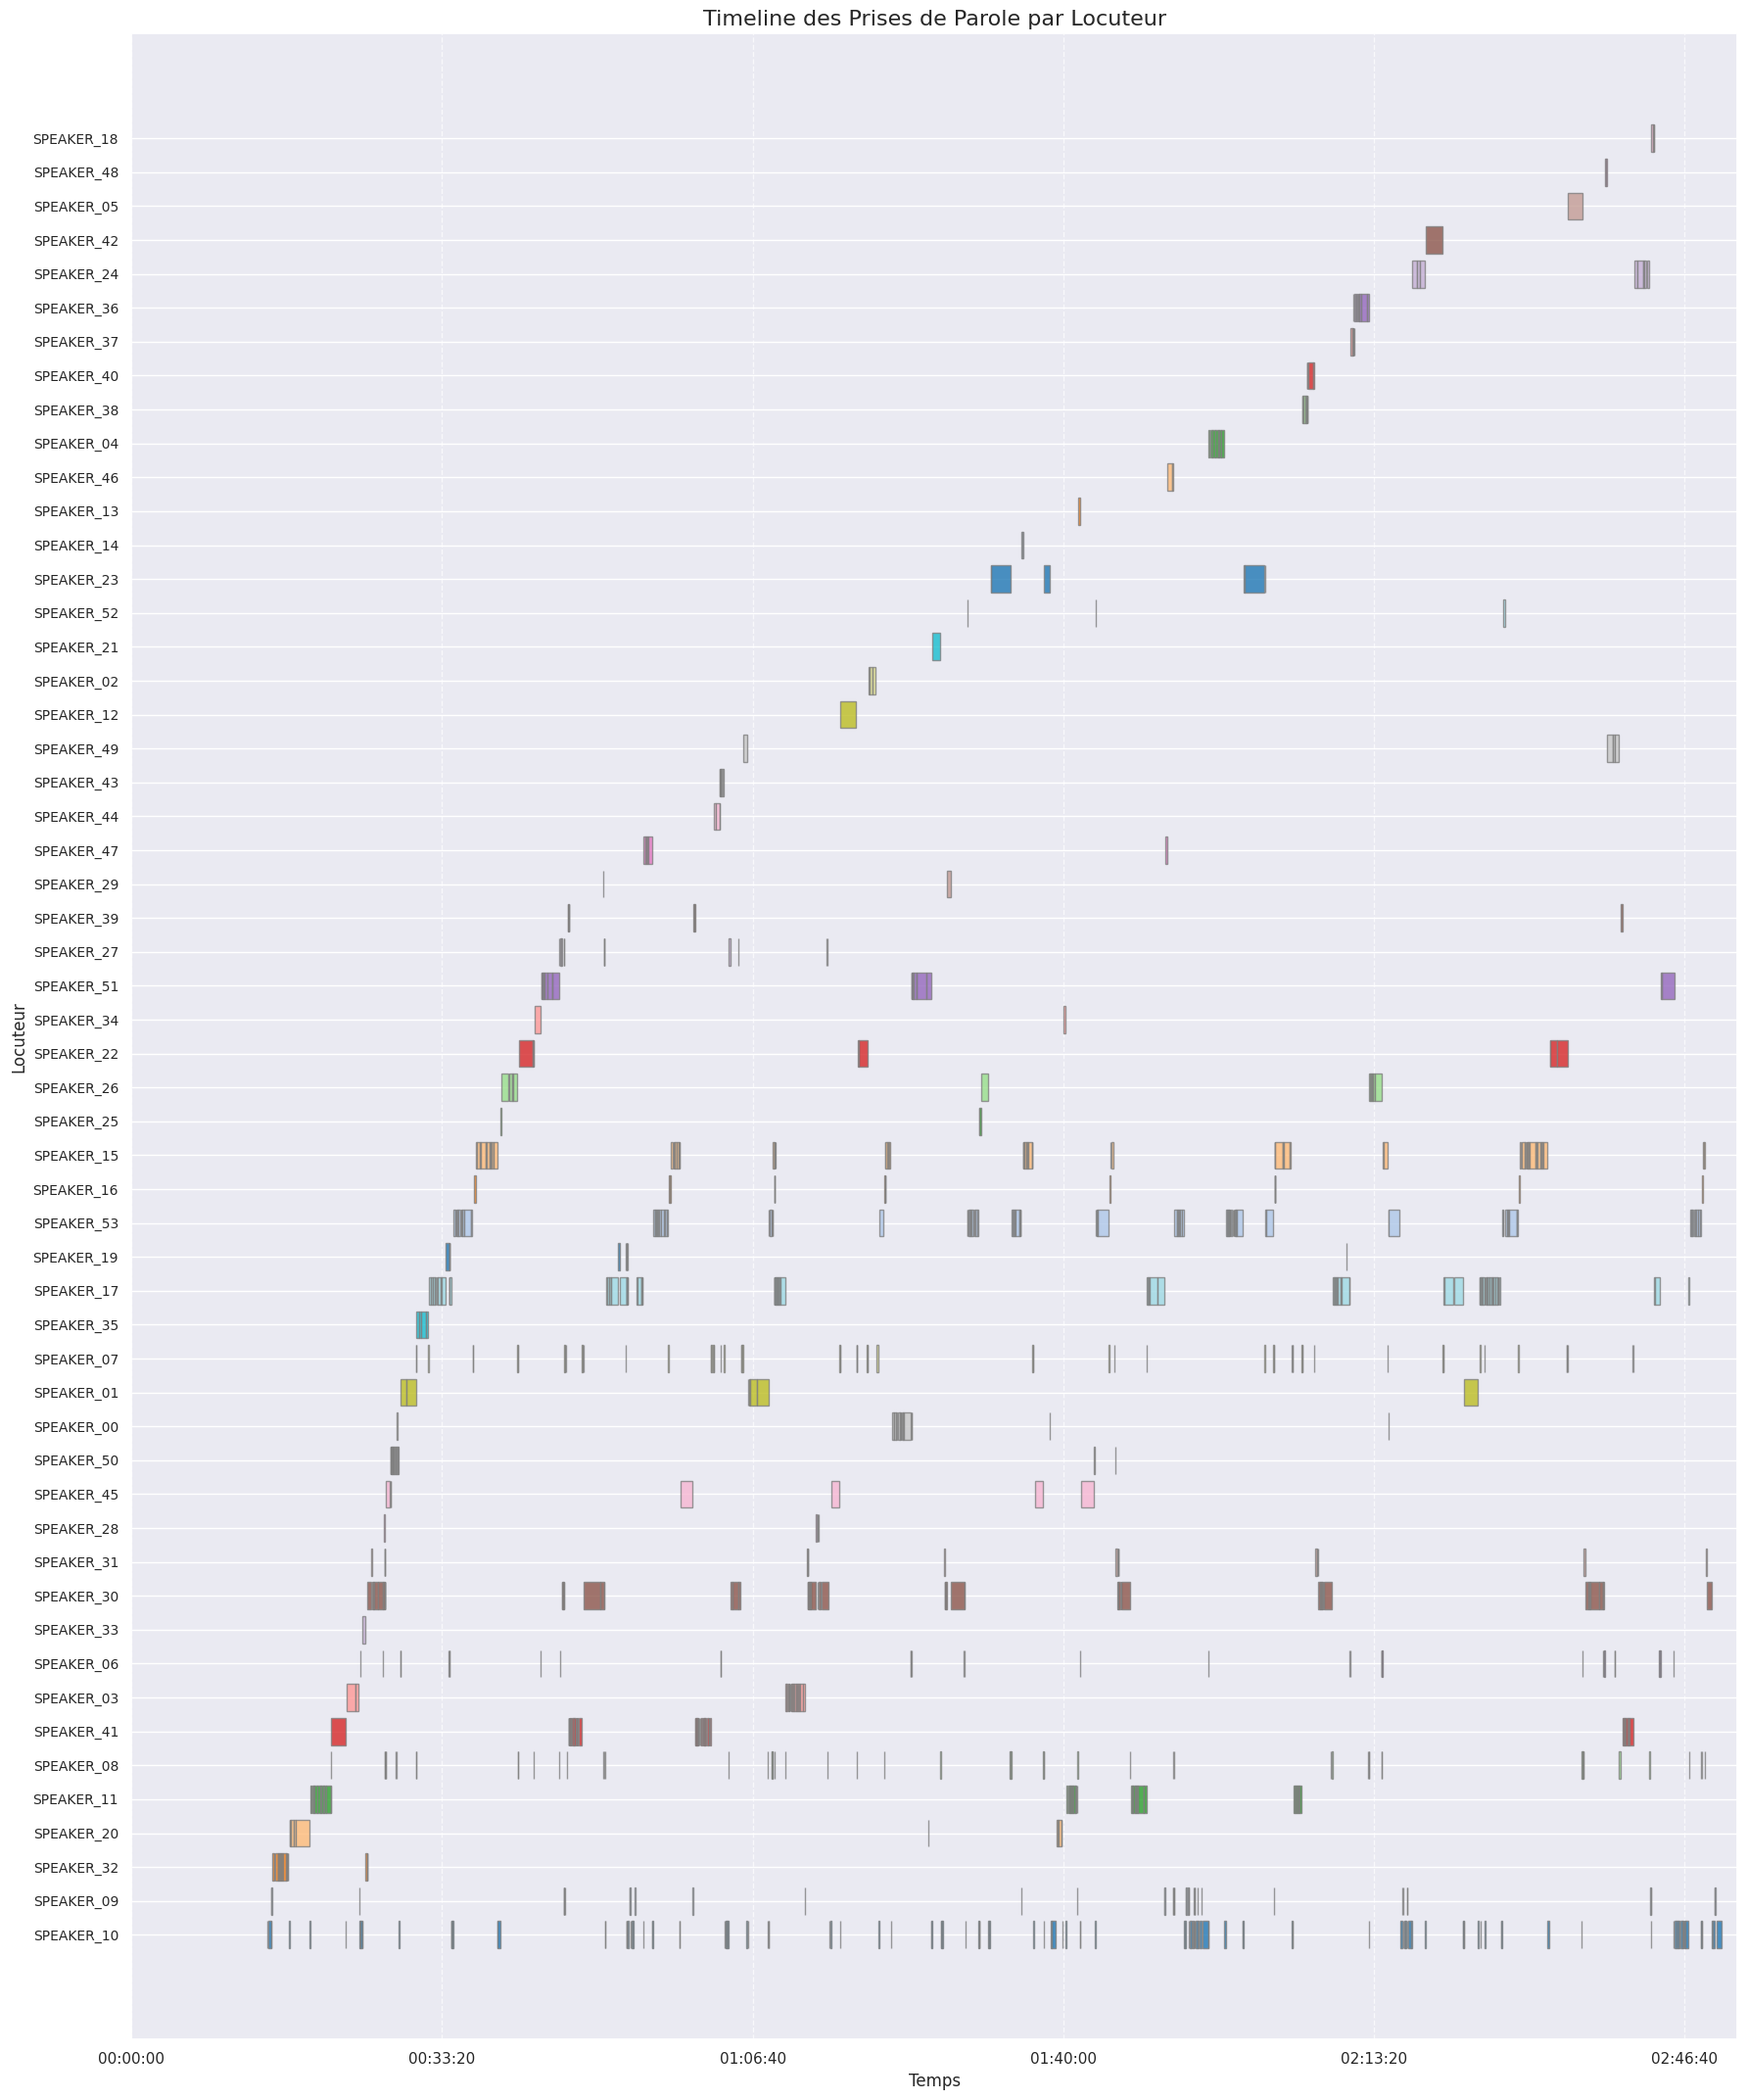

In [118]:
fig_height = max(8, y_index_counter * 0.4)
plt.figure(figsize=(18, fig_height))

colors = sns.color_palette("tab20", n_colors=y_index_counter)

for idx, row in df_timeline.iterrows():
    speaker_y_pos = row['y_index']
    start_time = row['start']
    duration = row['duration']
    
    color = colors[speaker_y_pos % len(colors)]

    plt.barh(speaker_y_pos, duration, left=start_time, height=0.8, color=color, edgecolor='grey', alpha=0.8)

plt.yticks(y_ticks_positions, y_ticks_labels, fontsize=10)
plt.xlabel("Temps", fontsize=12) # Retirer "(secondes)" car le format hh:mm:ss est explicite
plt.ylabel("Locuteur", fontsize=12)
plt.title("Timeline des Prises de Parole par Locuteur", fontsize=16)
plt.xlim(0, max_time + 5)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# --- Application du formatage hh:mm:ss à l'axe X ---
ax = plt.gca() # Obtenir les axes actuels du graphique
ax.xaxis.set_major_formatter(time_formatter)

plt.tight_layout()
plt.show()

In [139]:
top_3_speakers_labels = [speaker for speaker, duration in sorted_speakers_by_duration[:3]]
for speaker, duration in sorted_speakers_by_duration[:3]:
    print(f"- {speaker}: {duration/60:.2f} minutes")

- SPEAKER_53: 15.40 minutes
- SPEAKER_30: 14.62 minutes
- SPEAKER_17: 14.39 minutes


In [140]:

plot_data_top3 = []
speaker_to_y_index_top3 = {} # Nouvelle map pour les indices Y des top 3
y_index_counter_top3 = 0


In [141]:
plot_data_top3 = []
speaker_to_y_index_top3 = {} # Nouvelle map pour les indices Y des top 3
y_index_counter_top3 = 0

# Assigner des indices Y uniquement aux top 3 locuteurs et dans un ordre cohérent
for speaker_label in top_3_speakers_labels:
    if speaker_label not in speaker_to_y_index_top3:
        speaker_to_y_index_top3[speaker_label] = y_index_counter_top3
        y_index_counter_top3 += 1

# Filtrer les segments pour n'inclure que les top 3 locuteurs
for segment, _, label in diarization.itertracks(yield_label=True):
    if label in top_3_speakers_labels:
        plot_data_top3.append({
            'speaker_label': label,
            'y_index': speaker_to_y_index_top3[label],
            'start': segment.start,
            'duration': segment.duration
        })

df_timeline_top3 = pd.DataFrame(plot_data_top3)


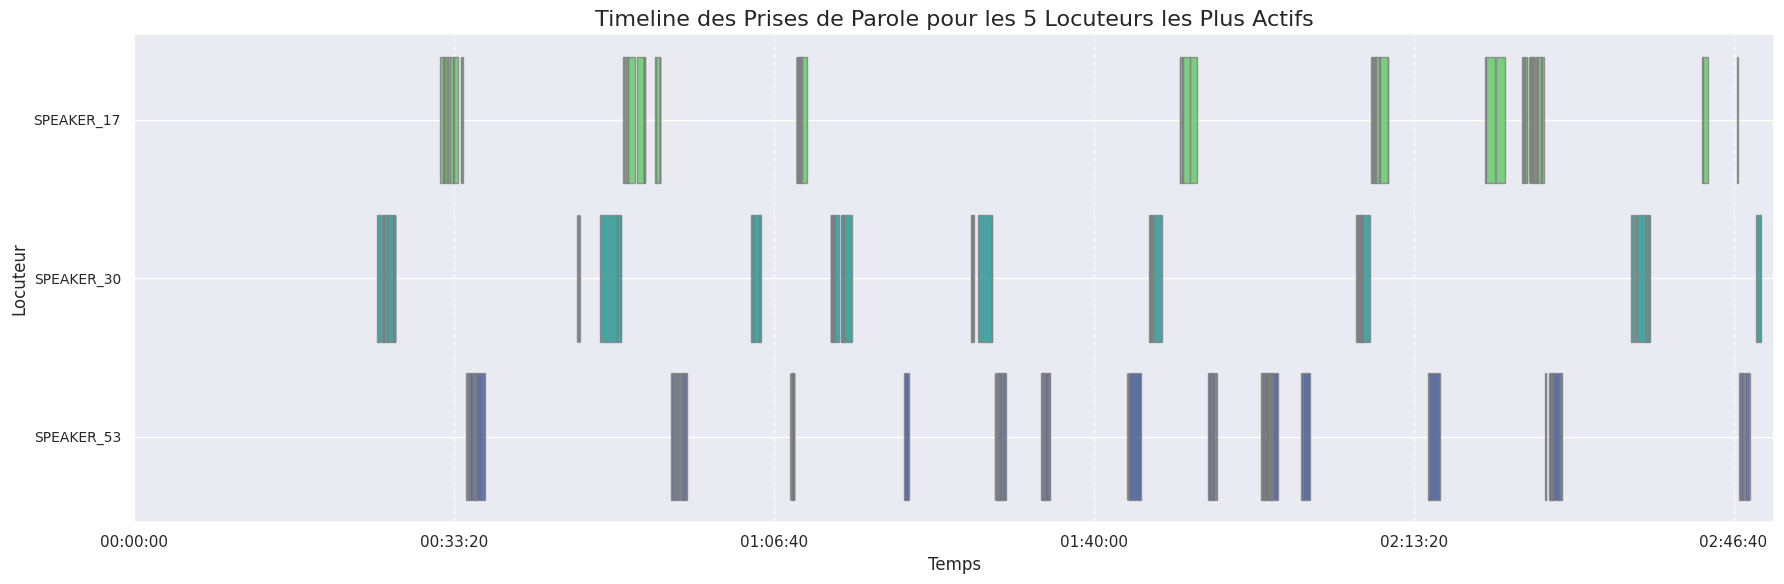

In [146]:
y_ticks_labels_top3 = top_3_speakers_labels
y_ticks_positions_top3 = [speaker_to_y_index_top3[label] for label in top_3_speakers_labels]

# Déterminer la durée totale de l'audio pour l'axe X (basée sur tous les segments, pas seulement top 3)
max_time = df_timeline_top3['start'].max() + df_timeline_top3['duration'].max() if not df_timeline_top3.empty else 60


# --- 4. Tracé du Diagramme de Gantt simplifié / Timeline pour les Top 3 ---

# La hauteur de la figure sera fixe car il n'y a que 3 locuteurs
fig_height = 6 # Hauteur raisonnable pour 3 barres
plt.figure(figsize=(18, fig_height))

# Utiliser une palette avec un nombre suffisant de couleurs distinctes (e.g., 5 couleurs pour 5 locuteurs)
colors = sns.color_palette("viridis", n_colors=len(top_3_speakers_labels))
color_map = {label: colors[i] for i, label in enumerate(top_3_speakers_labels)}


# Dessiner chaque segment
for idx, row in df_timeline_top3.iterrows():
    speaker_y_pos = row['y_index']
    start_time = row['start']
    duration = row['duration']
    
    color = color_map[row['speaker_label']] # Utiliser la couleur spécifique au locuteur

    plt.barh(speaker_y_pos, duration, left=start_time, height=0.8, color=color, edgecolor='grey', alpha=0.8)

plt.yticks(y_ticks_positions_top3, y_ticks_labels_top3, fontsize=10)
plt.xlabel("Temps", fontsize=12)
plt.ylabel("Locuteur", fontsize=12)
plt.title(f"Timeline des Prises de Parole pour les {len(top_5_speakers_labels)} Locuteurs les Plus Actifs", fontsize=16)
plt.xlim(0, max_time + 5)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# --- Application du formatage hh:mm:ss à l'axe X ---
ax = plt.gca()
ax.xaxis.set_major_formatter(time_formatter)

plt.tight_layout()
plt.show()

In [143]:
min_segment_duration_threshold = 2 # secondes

zoom_start_time = None 
zoom_end_time = None 

In [144]:

df_timeline_top3 = pd.DataFrame(plot_data_top3)

y_ticks_labels_top3 = top_3_speakers_labels
y_ticks_positions_top3 = [speaker_to_y_index_top3[label] for label in top_3_speakers_labels]

# Déterminer la fin maximale de la timeline (utilisé si pas de zoom manuel)
max_end_time_overall = df_timeline_top3['start'].max() + df_timeline_top3['duration'].max() if not df_timeline_top3.empty else 60


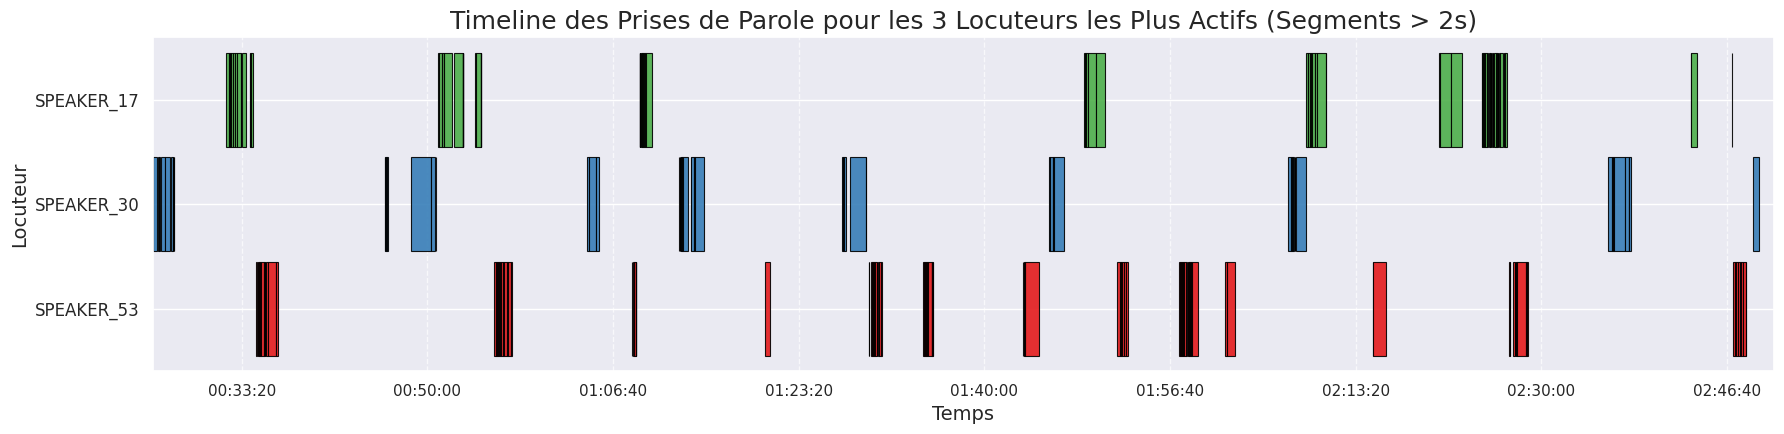

In [145]:
time_formatter = FuncFormatter(format_time)
fig_height = 4.5
plt.figure(figsize=(18, fig_height))

colors = sns.color_palette("Set1", n_colors=len(top_3_speakers_labels))
color_map = {label: colors[i] for i, label in enumerate(top_3_speakers_labels)}

for idx, row in df_timeline_top3.iterrows():
    speaker_y_pos = row['y_index']
    start_time = row['start']
    duration = row['duration']
    
    color = color_map[row['speaker_label']]

    plt.barh(speaker_y_pos, duration, left=start_time, height=0.9,
             color=color, edgecolor='black', linewidth=0.8, alpha=0.9)

plt.yticks(y_ticks_positions_top3, y_ticks_labels_top3, fontsize=12)
plt.xlabel("Temps", fontsize=14)
plt.ylabel("Locuteur", fontsize=14)
plt.title(f"Timeline des Prises de Parole pour les {len(top_3_speakers_labels)} Locuteurs les Plus Actifs (Segments > {min_segment_duration_threshold}s)", fontsize=18)
plt.grid(axis='x', linestyle='--', alpha=0.7)

if zoom_start_time is not None and zoom_end_time is not None:
    # Si un zoom manuel est défini, on le respecte
    plt.xlim(zoom_start_time, zoom_end_time)
else:
    # Sinon, on calcule le début automatique
    earliest_start_time_top3 = df_timeline_top3['start'].min() if not df_timeline_top3.empty else 0
    # On ajoute une petite marge avant le premier segment, en s'assurant de ne pas descendre en dessous de 0
    x_min_auto = max(0, earliest_start_time_top3 - 1) 
    
    # La fin de l'axe X reste basée sur la fin du dernier segment + une marge
    x_max_auto = max_end_time_overall + 5
    
    plt.xlim(x_min_auto, x_max_auto)

ax = plt.gca()
ax.xaxis.set_major_formatter(time_formatter)

plt.tight_layout()
plt.show()

In [147]:
csv_filename = "timeline_top3_speakers.csv"
df_timeline_top3_export = df_timeline_top3[['speaker_label', 'start', 'duration']]
    
df_timeline_top3_export.to_csv(csv_filename, index=False)
print(f"\n--- Données de la timeline exportées vers '{csv_filename}' ---")
print("Colonnes exportées : 'speaker_label', 'start', 'duration'")


--- Données de la timeline exportées vers 'timeline_top3_speakers.csv' ---
Colonnes exportées : 'speaker_label', 'start', 'duration'
